In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from collections import Counter
import pickle
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [120]:
def plot_roc(model, x_columns, y_true, title="model type"):

    y_pred = model.predict_proba(x_columns)

    fpr, tpr, threshold = roc_curve(y_true, y_pred[:,1])
    area_under_curve = auc(fpr, tpr)

    # method I: plt
    fig, ax = plt.subplots()
    if title == "model type":
        model_name = str(type(model)).split('.')[-1].strip(">\'")
    else:
        model_name = title
        
    plt.title(f'{model_name} ROC')
    ax.plot(fpr, tpr, 'k', label = 'C AUC = %0.3f' % area_under_curve)

    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_best_features(model, x_cols, n_features):
    
    feature_importances = {}
    
    for i in range(len(model.feature_importances_)):
        
        feature_importances[x_cols[i]] = model.feature_importances_[i]
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, n_features=10, figsize_x=10, figsize_y=10):
    
    values = values[:n_features]
    
    features = features[:n_features]
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y), fontsize=80)

In [49]:
try:
    df = pd.read_json('../data/featurized_dataframe.json')
    print("Dataframe read from local .json")
except ValueError:
    print("Dataframe json being read from s3. Consider running \'featurize.py\' first if you'll be running this\
            multiple times.")
    df = pd.read_json('https://s3-us-west-2.amazonaws.com/businesspredictiondata/featurized_dataframe.json')

yelp_basic = ['restaurant_count','restaurant_count > 1','restaurant_count > 5',
                'restaurant_count > 25','review_count','stars']

yelp_categories = [col for col in df.columns if col.startswith('Category')]

yelp_attributes = [col for col in df.columns if col.startswith('Attribute')]

yelp_review_prefixes = ('one_star','two_to_four_star','five_star')
yelp_review_features = [col for col in df.columns if col.startswith(review_prefixes)]
top_yelp_review_features = rf_best_features(df, yelp_review_features, 100)[1]

all_yelp_columns = yelp_basic + yelp_attributes + yelp_categories + top_yelp_review_features

google_maps_nearby_columns = ['avg_price_level','avg_rating','num_nearby_restaurants','relative rating',
                            'price_level','relative_price']

census_columns = ['2016 ACS 5-Year Population Estimate',
                 'American Indian and Alaska Native alone',
                 'Asian alone',
                 'Black or African American alone',
                 'Census 2010 Total Population',
                 'Educational Attainment: Percent high school graduate or higher',
                 'Foreign Born Population',
                 'Hispanic or Latino (of any race)',
                 'Individuals below poverty level',
                 'Median Age',
                 'Median Household Income',
                 'Native Hawaiian and Other Pacific Islander alone',
                 'Some Other Race alone',
                 'Total housing units',
                 'Two or More Races',
                 'Veterans',
                 'White alone']

info_columns = ['name','city','state','postal_code','address','business_id','latitude','longitude','neighborhood']

all_columns = all_yelp_columns + google_maps_nearby_columns + census_columns

print("Column groups created")

Dataframe read from local .json
Column groups created


In [50]:
x_column_sets = {'Yelp Basic':yelp_basic, 'Yelp Categories':yelp_categories,
                'Yelp Attributes':yelp_attributes,'Top Yelp Review':top_yelp_review_features,
                'Google Maps Nearby':google_maps_nearby_columns,'All Yelp':all_yelp_columns,
                'Census - Economic Data by Zip Code':census_columns, 'All': all_columns}

In [63]:
x_df = df[x_column_sets['All']]

y_df = df[['closed_on_google']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.33, random_state=10)

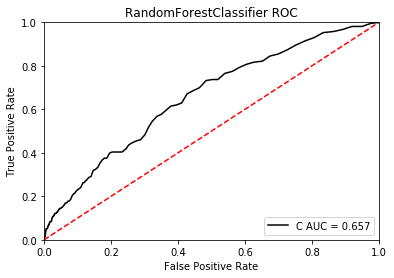

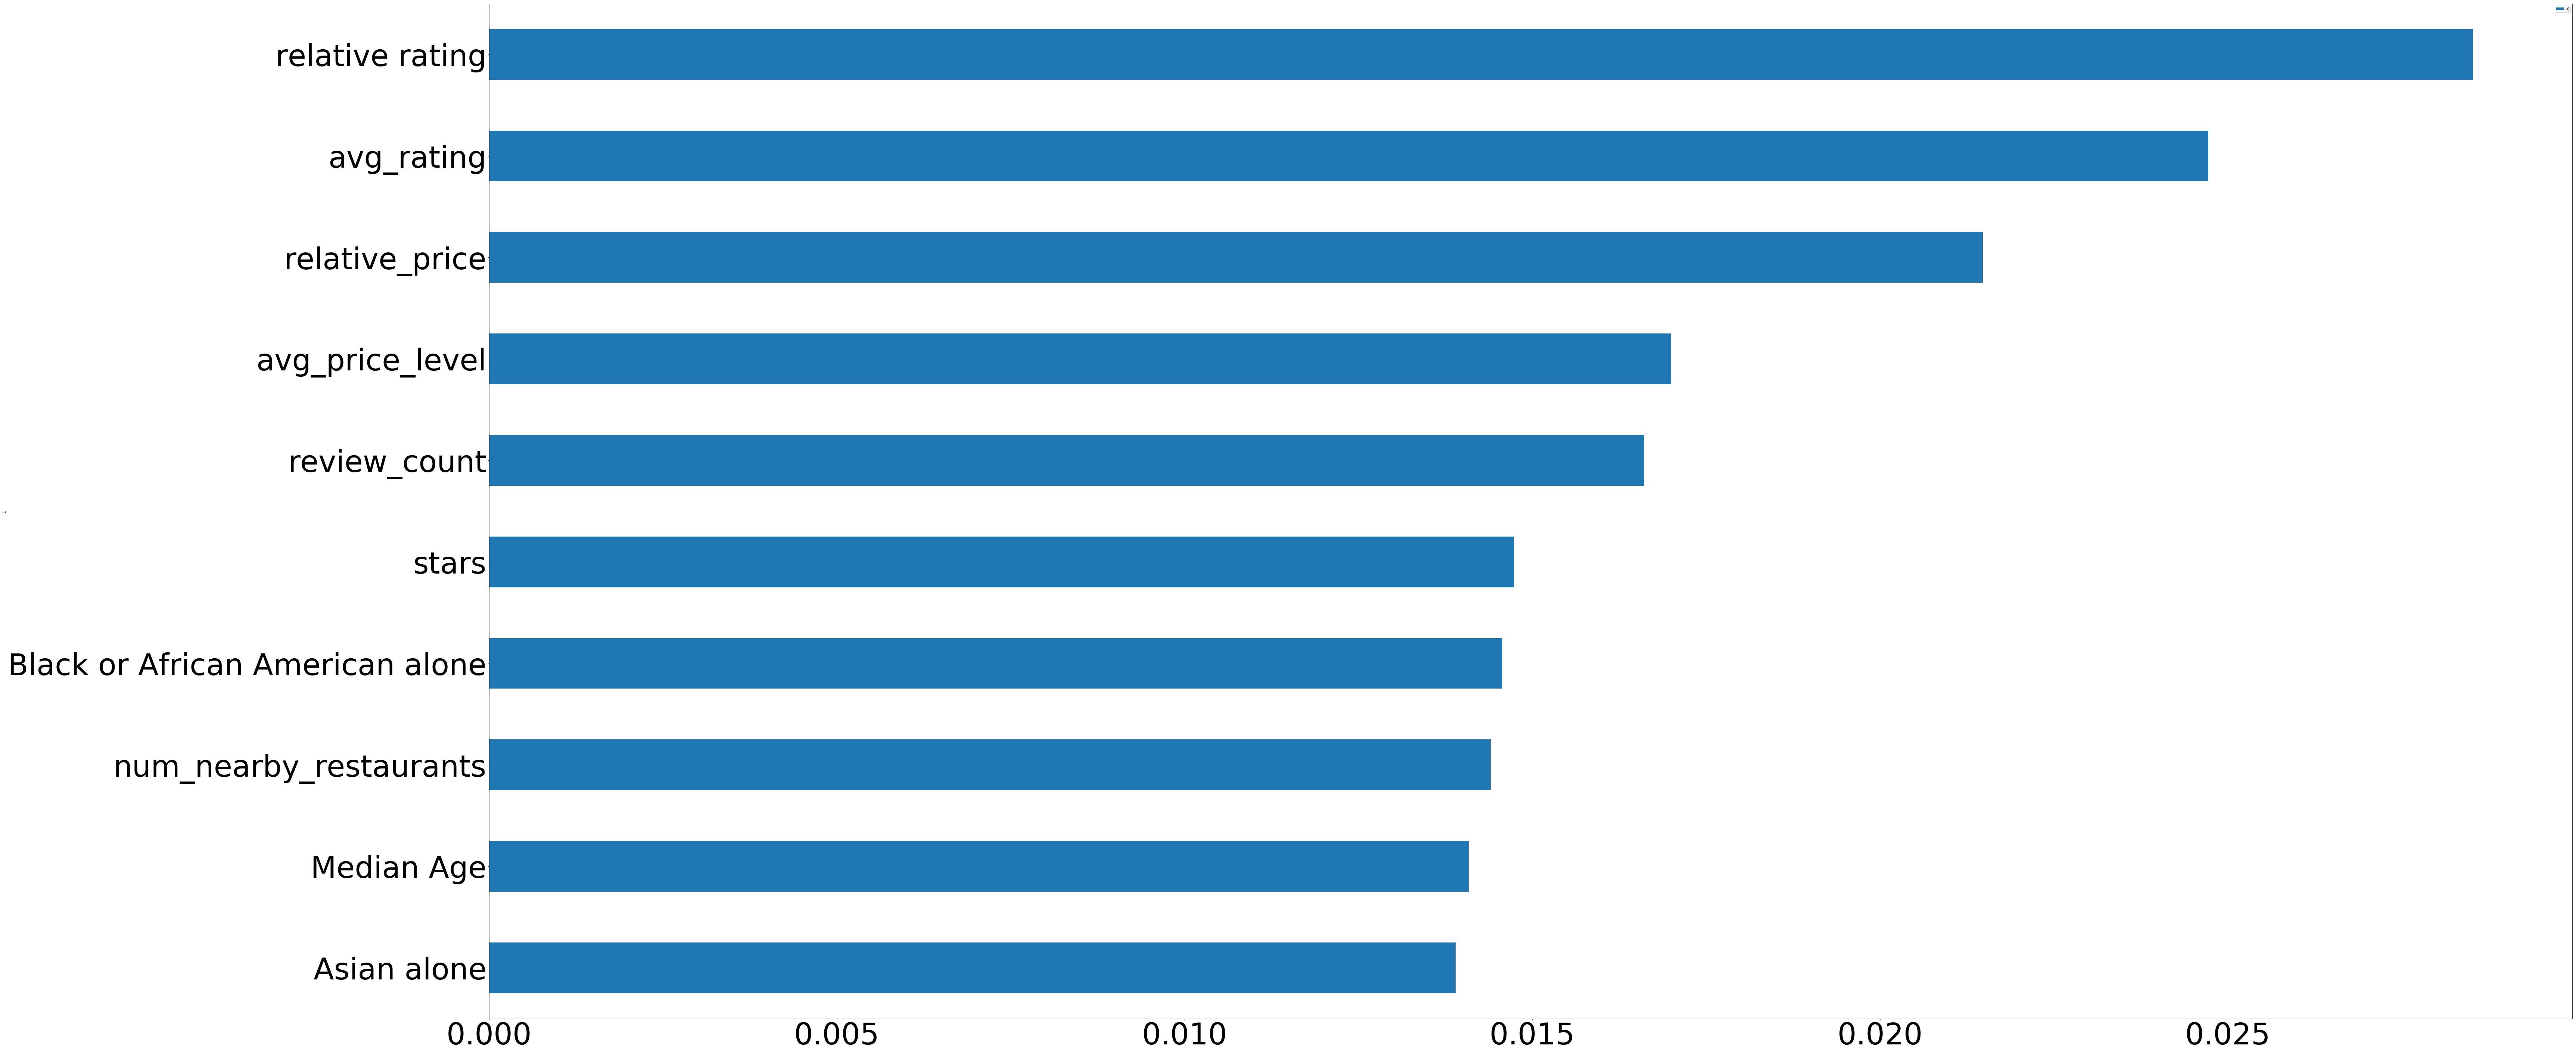

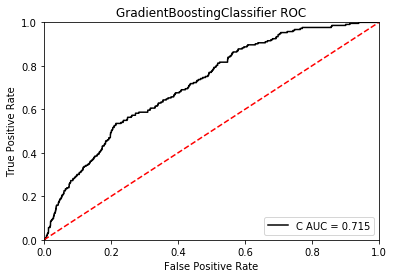

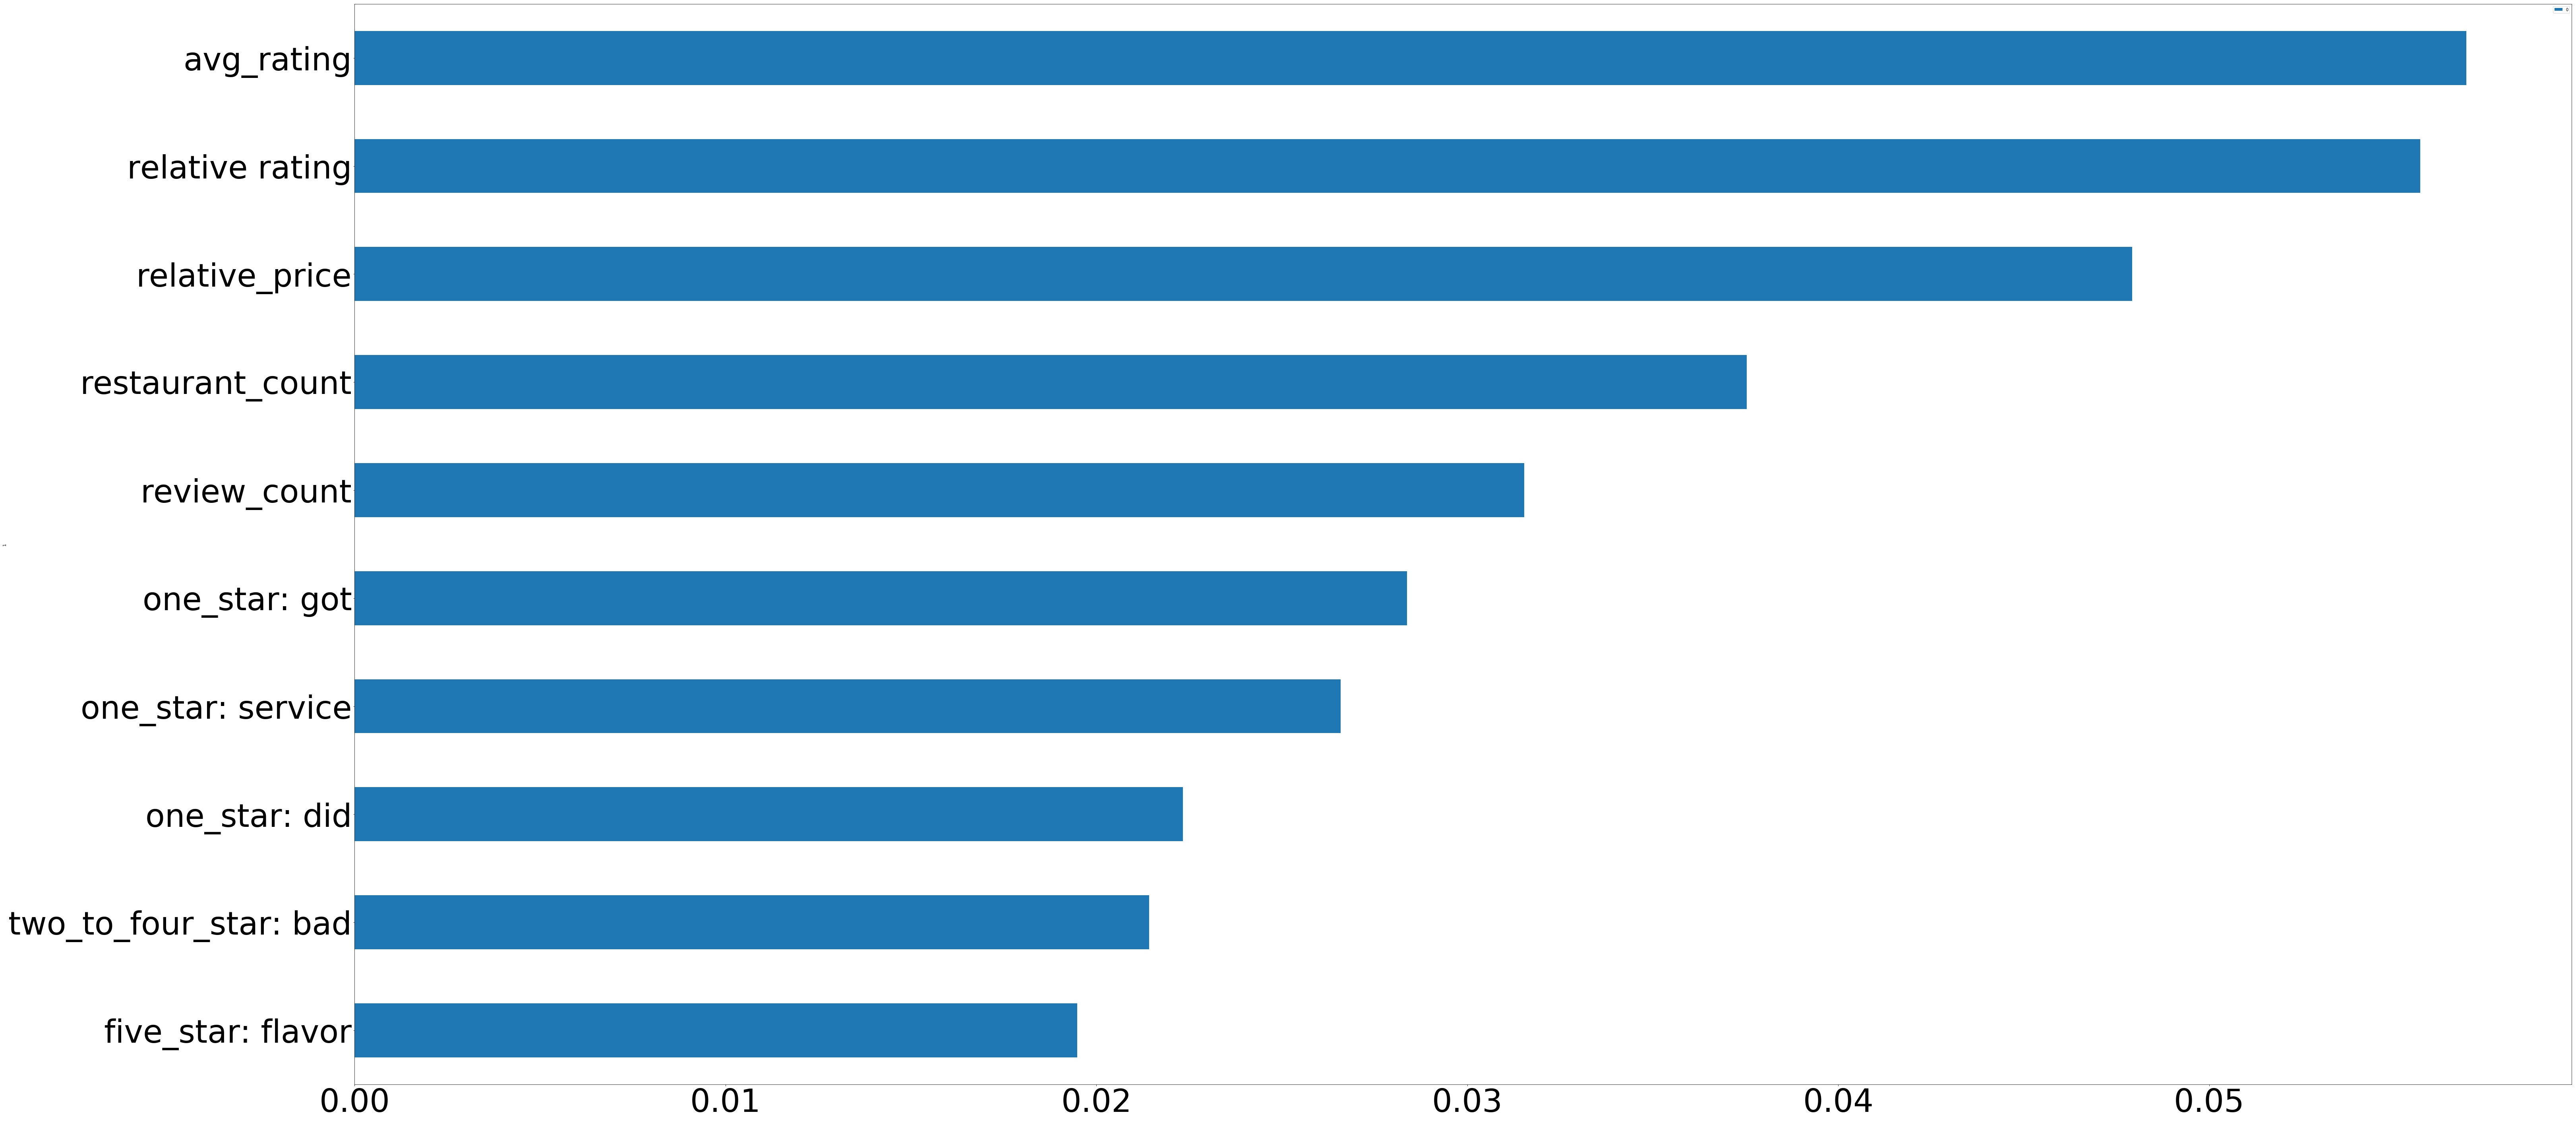

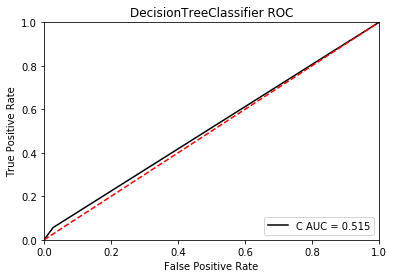

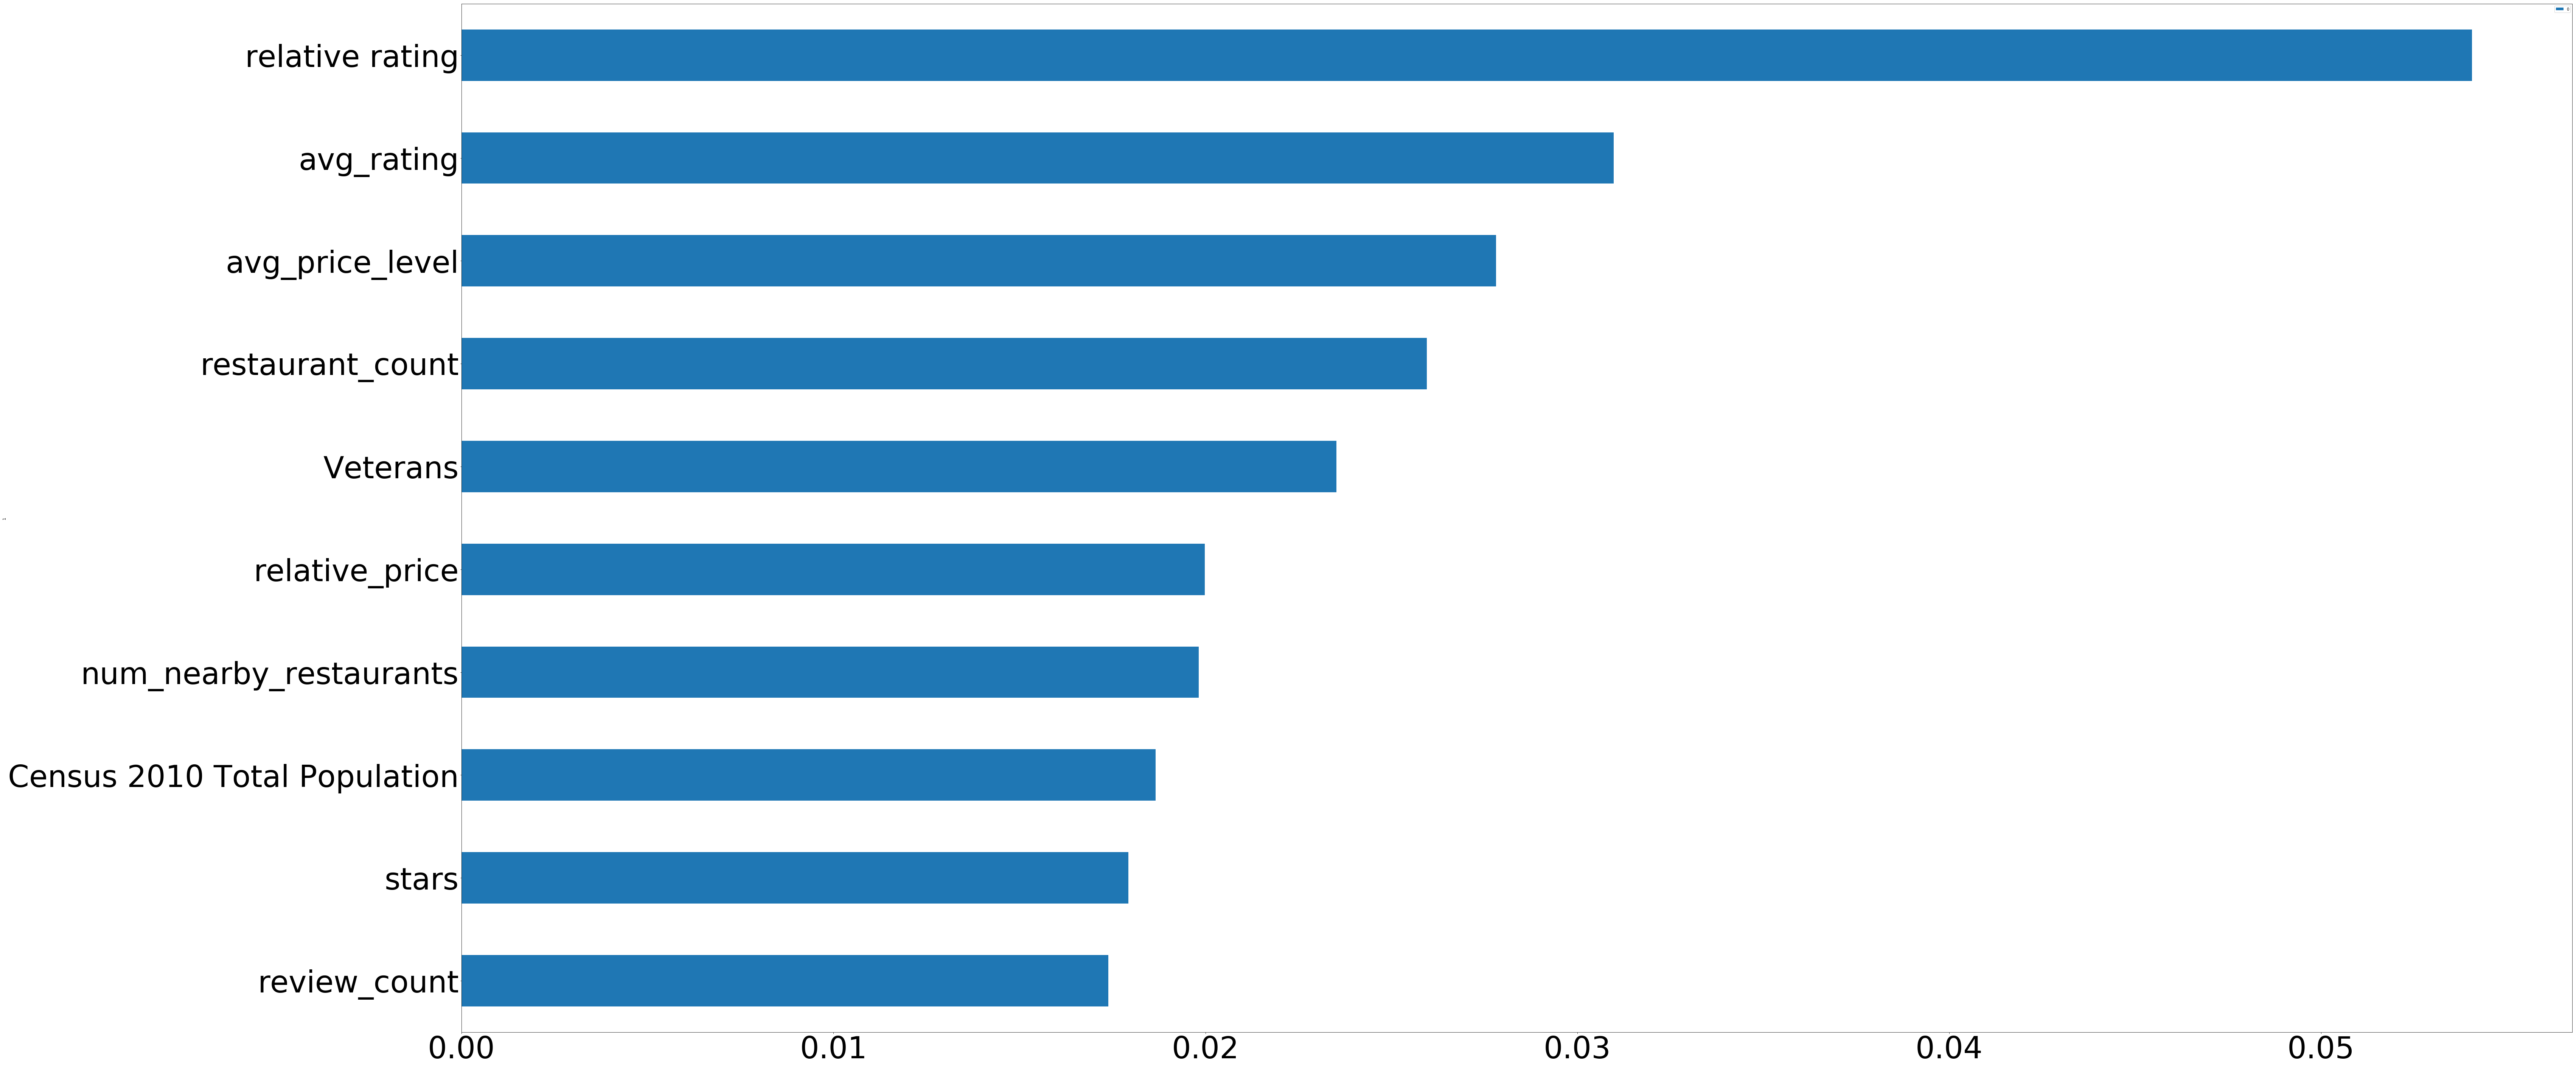

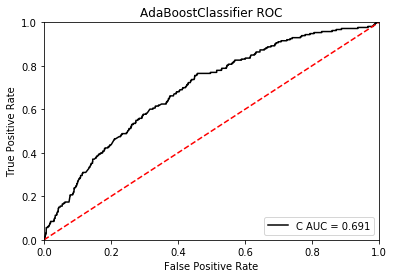

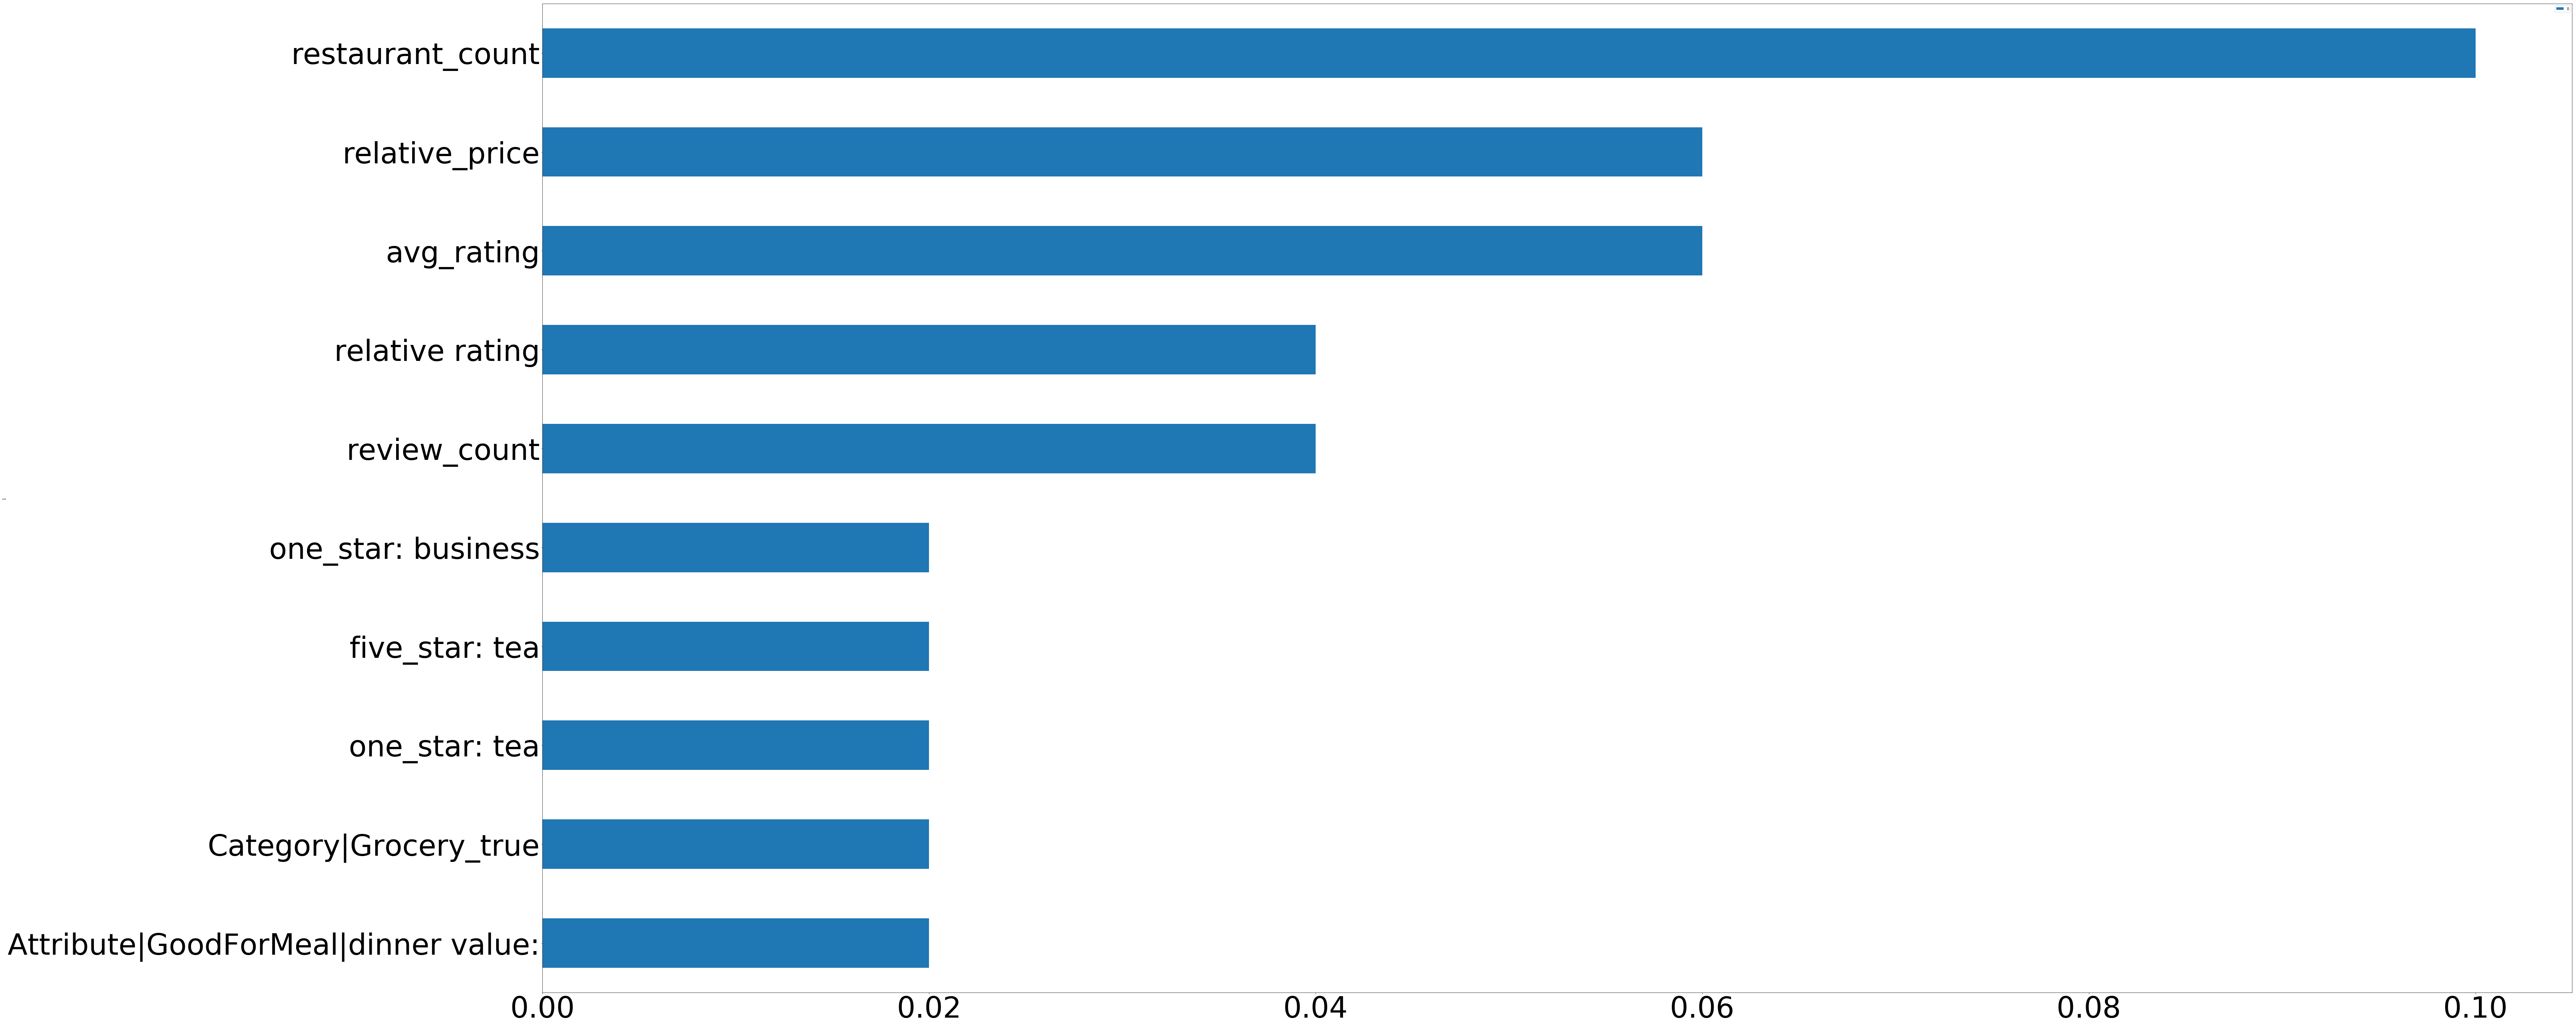

In [114]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
plot_roc(rf_model, X_test, y_test)
best_values, best_features = get_best_features(rf_model, X_test.columns, 10)
plot_best_features(best_values, best_features, 10, 100, 50)

gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)
plot_roc(gb_model, X_test, y_test)
best_values, best_features = get_best_features(gb_model, X_test.columns, 10)
plot_best_features(best_values, best_features, 10, 100, 50)

dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
plot_roc(dt_model, X_test, y_test)
best_values, best_features = get_best_features(dt_model, X_test.columns, 10)
plot_best_features(best_values, best_features, 10, 100, 50)

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)
plot_roc(ab_model, X_test, y_test)
best_values, best_features = get_best_features(ab_model, X_test.columns, 10)
plot_best_features(best_values, best_features, 10, 100, 50)

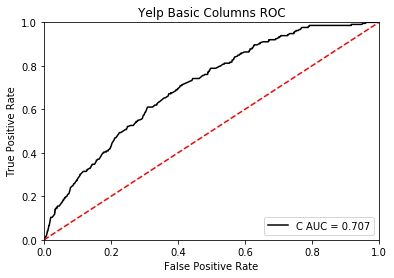

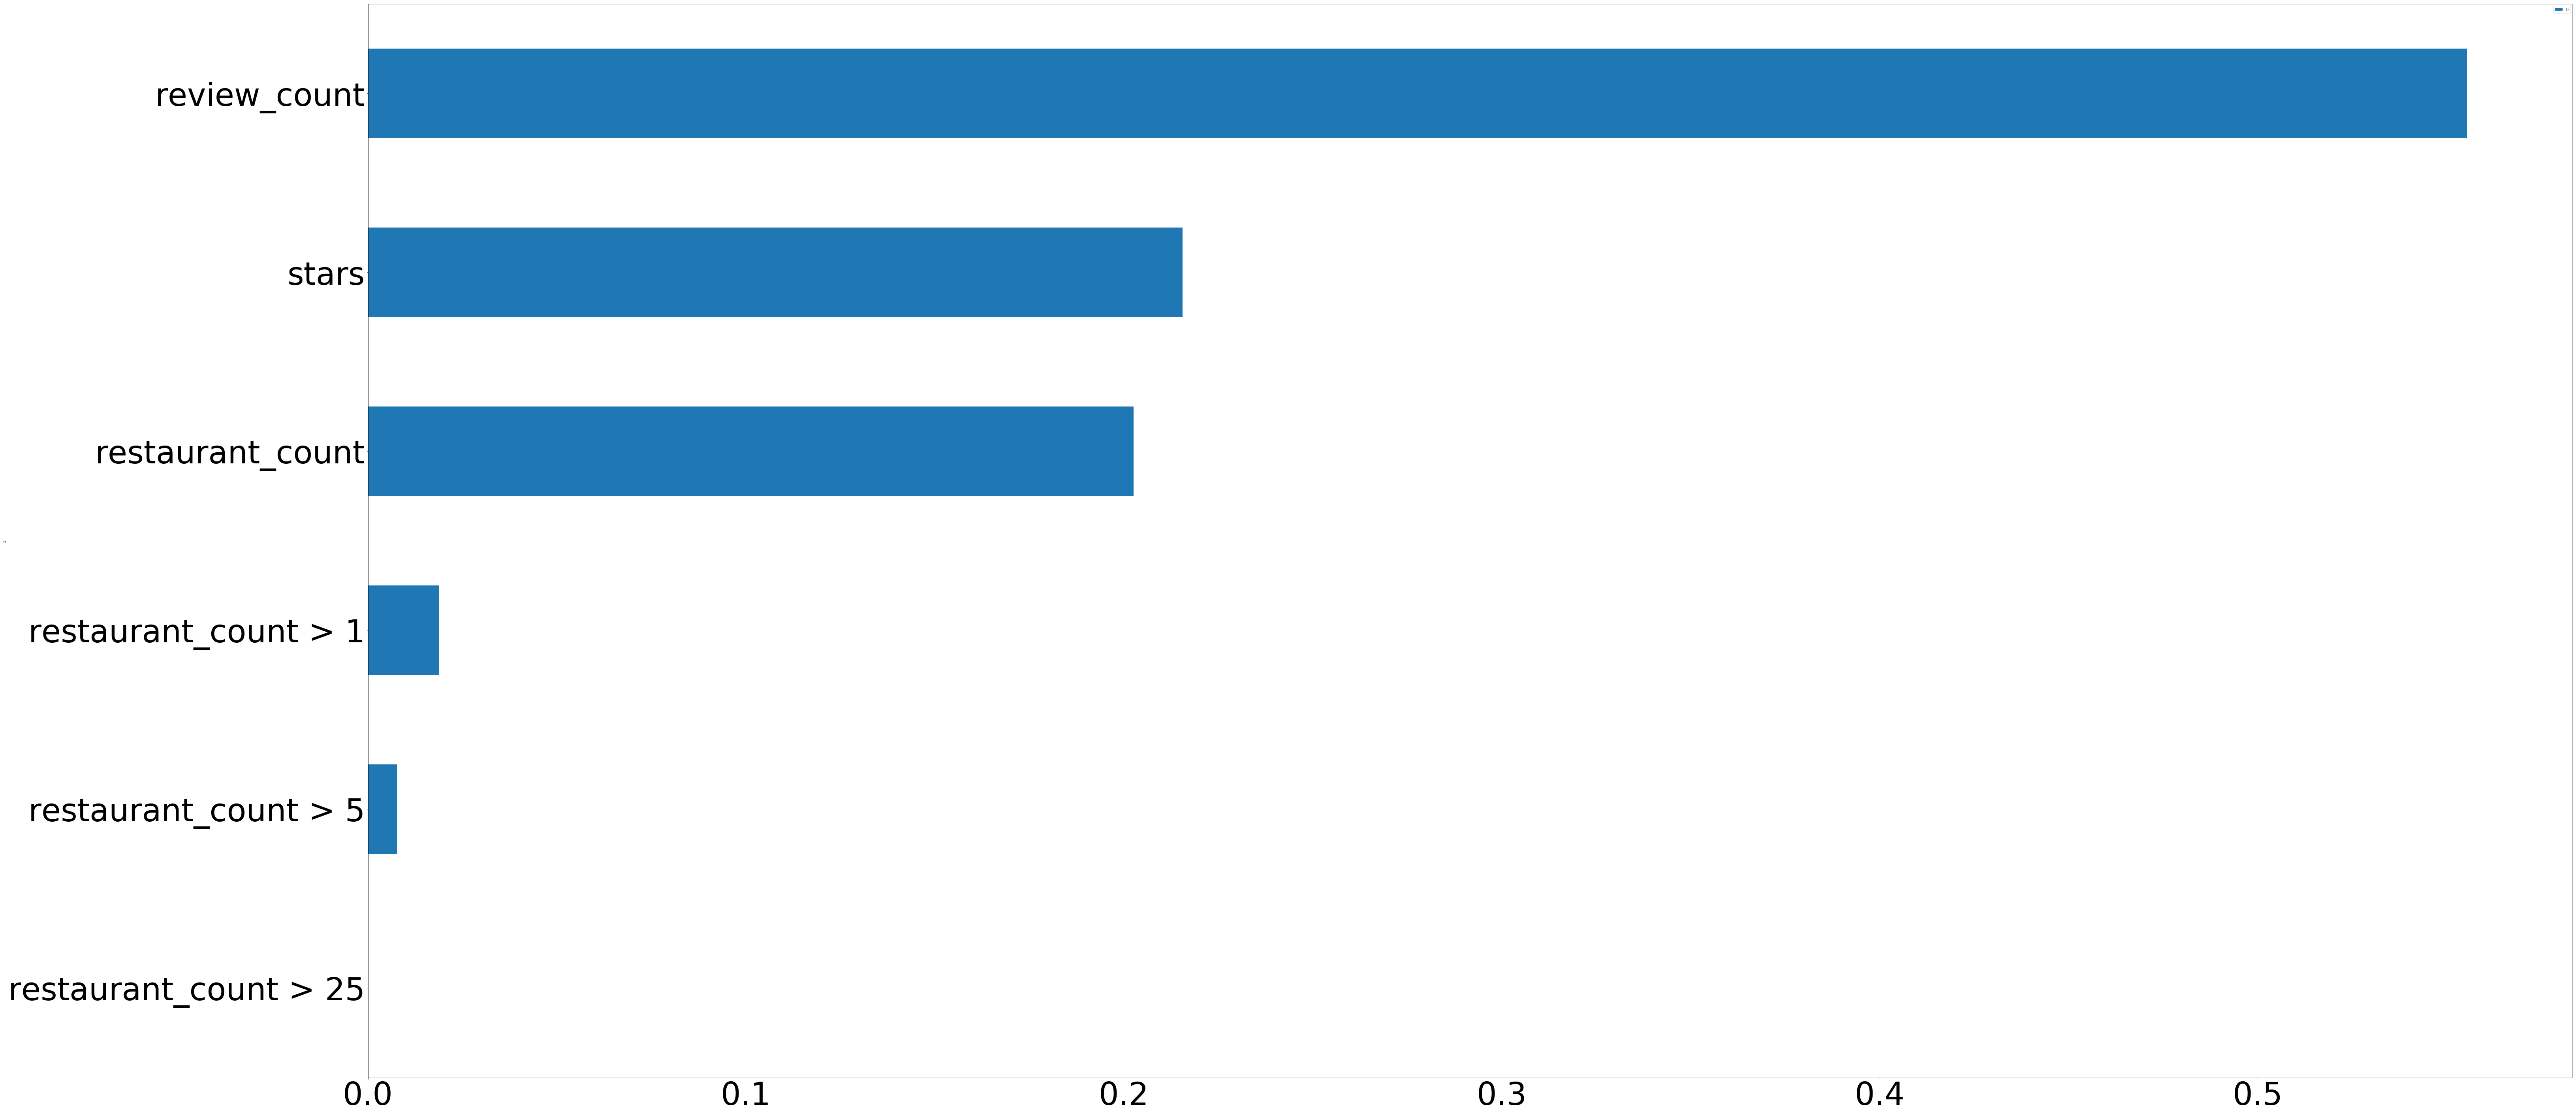

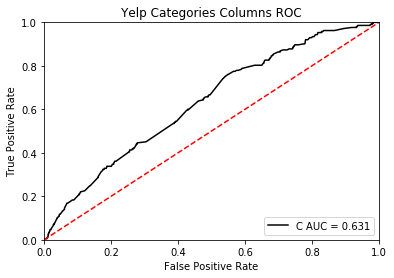

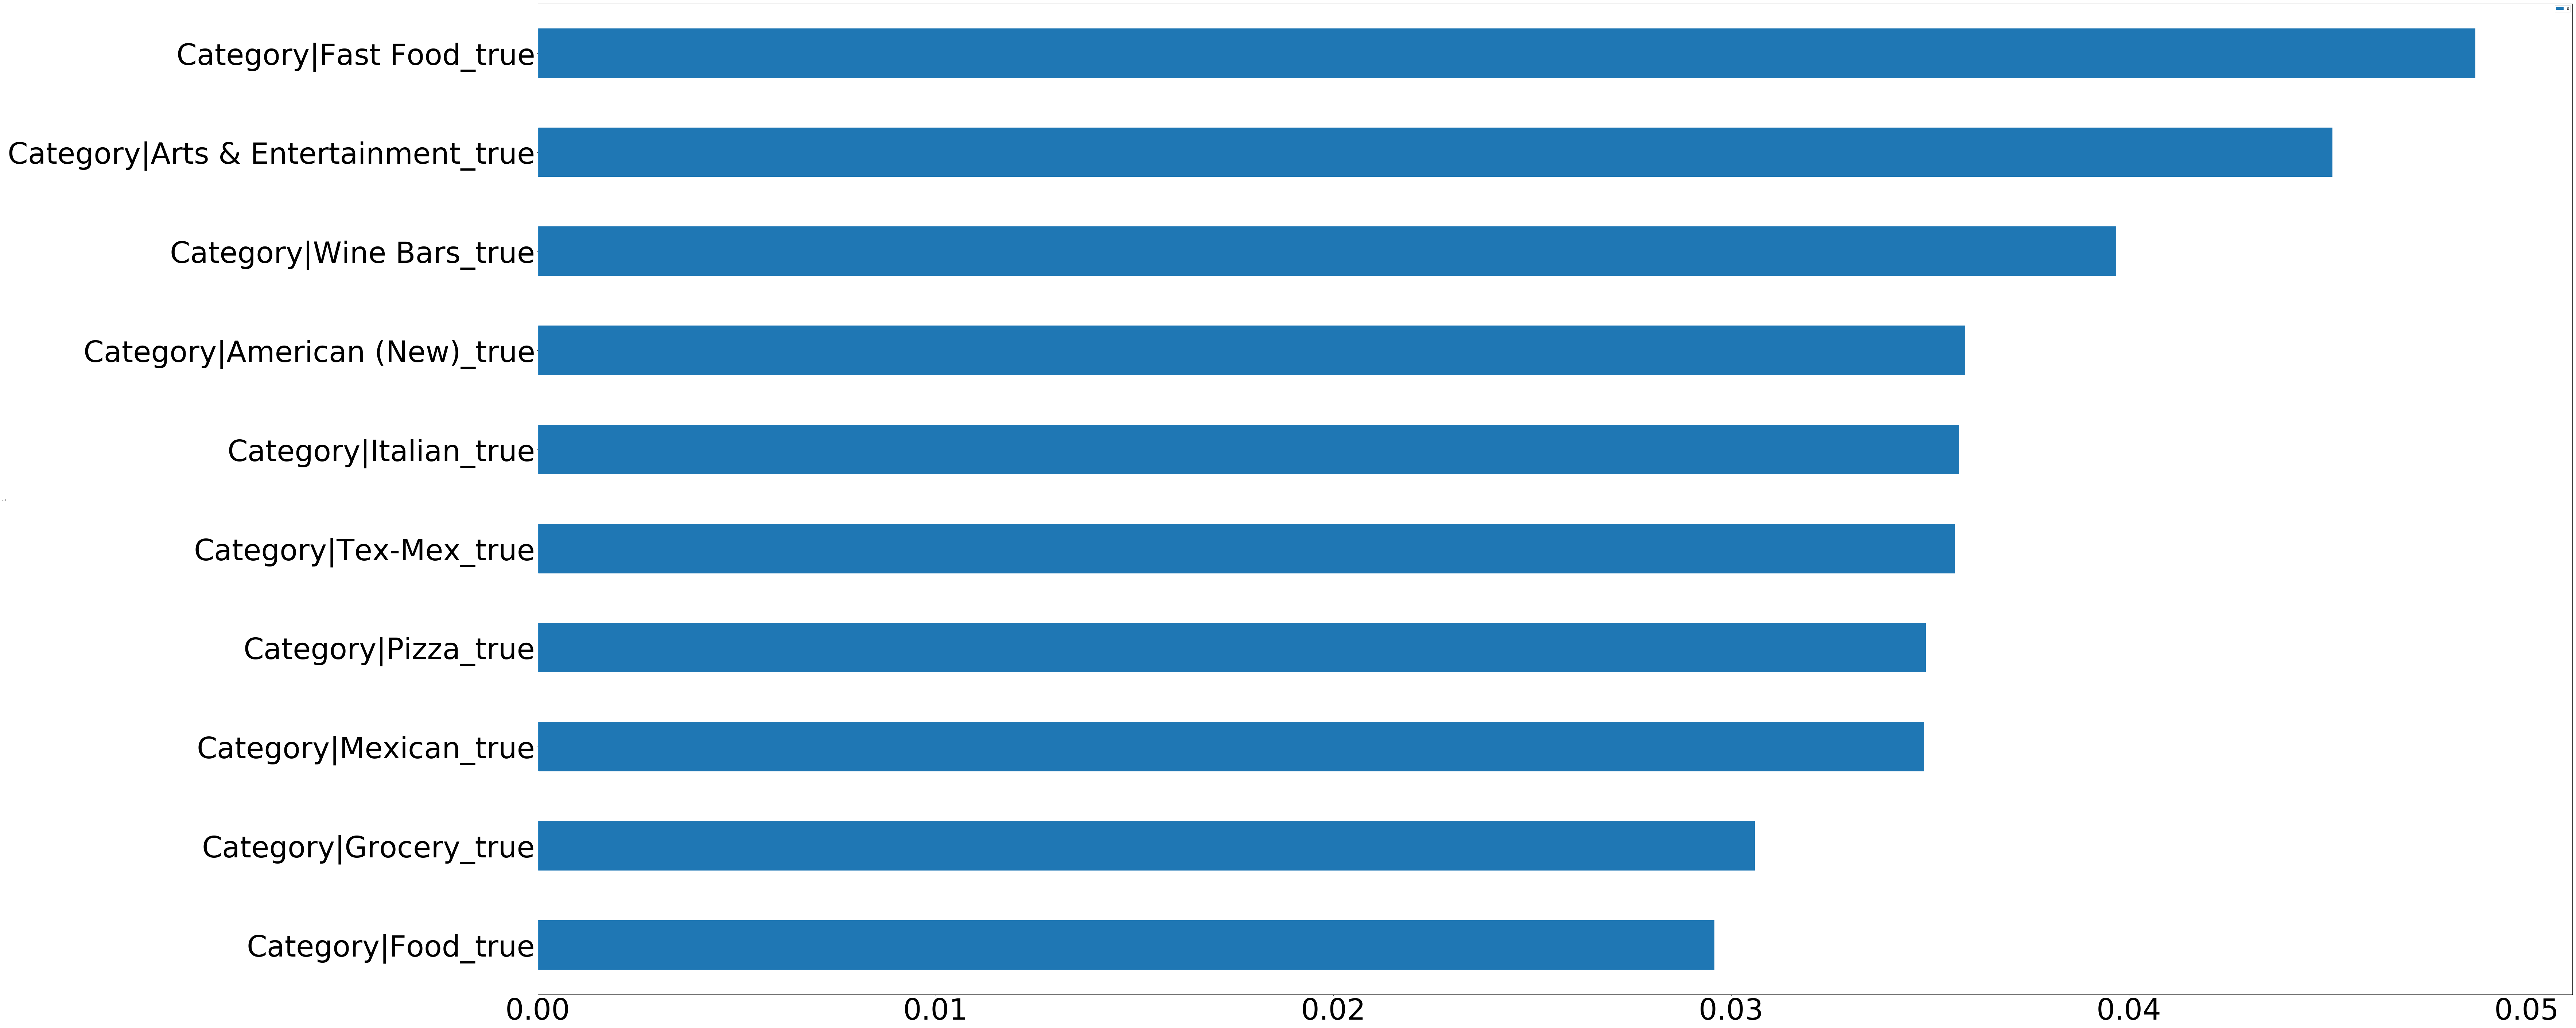

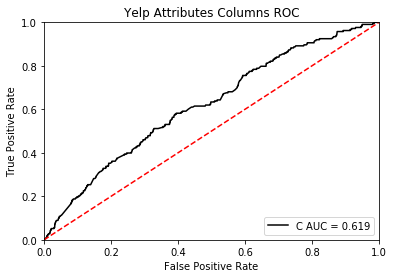

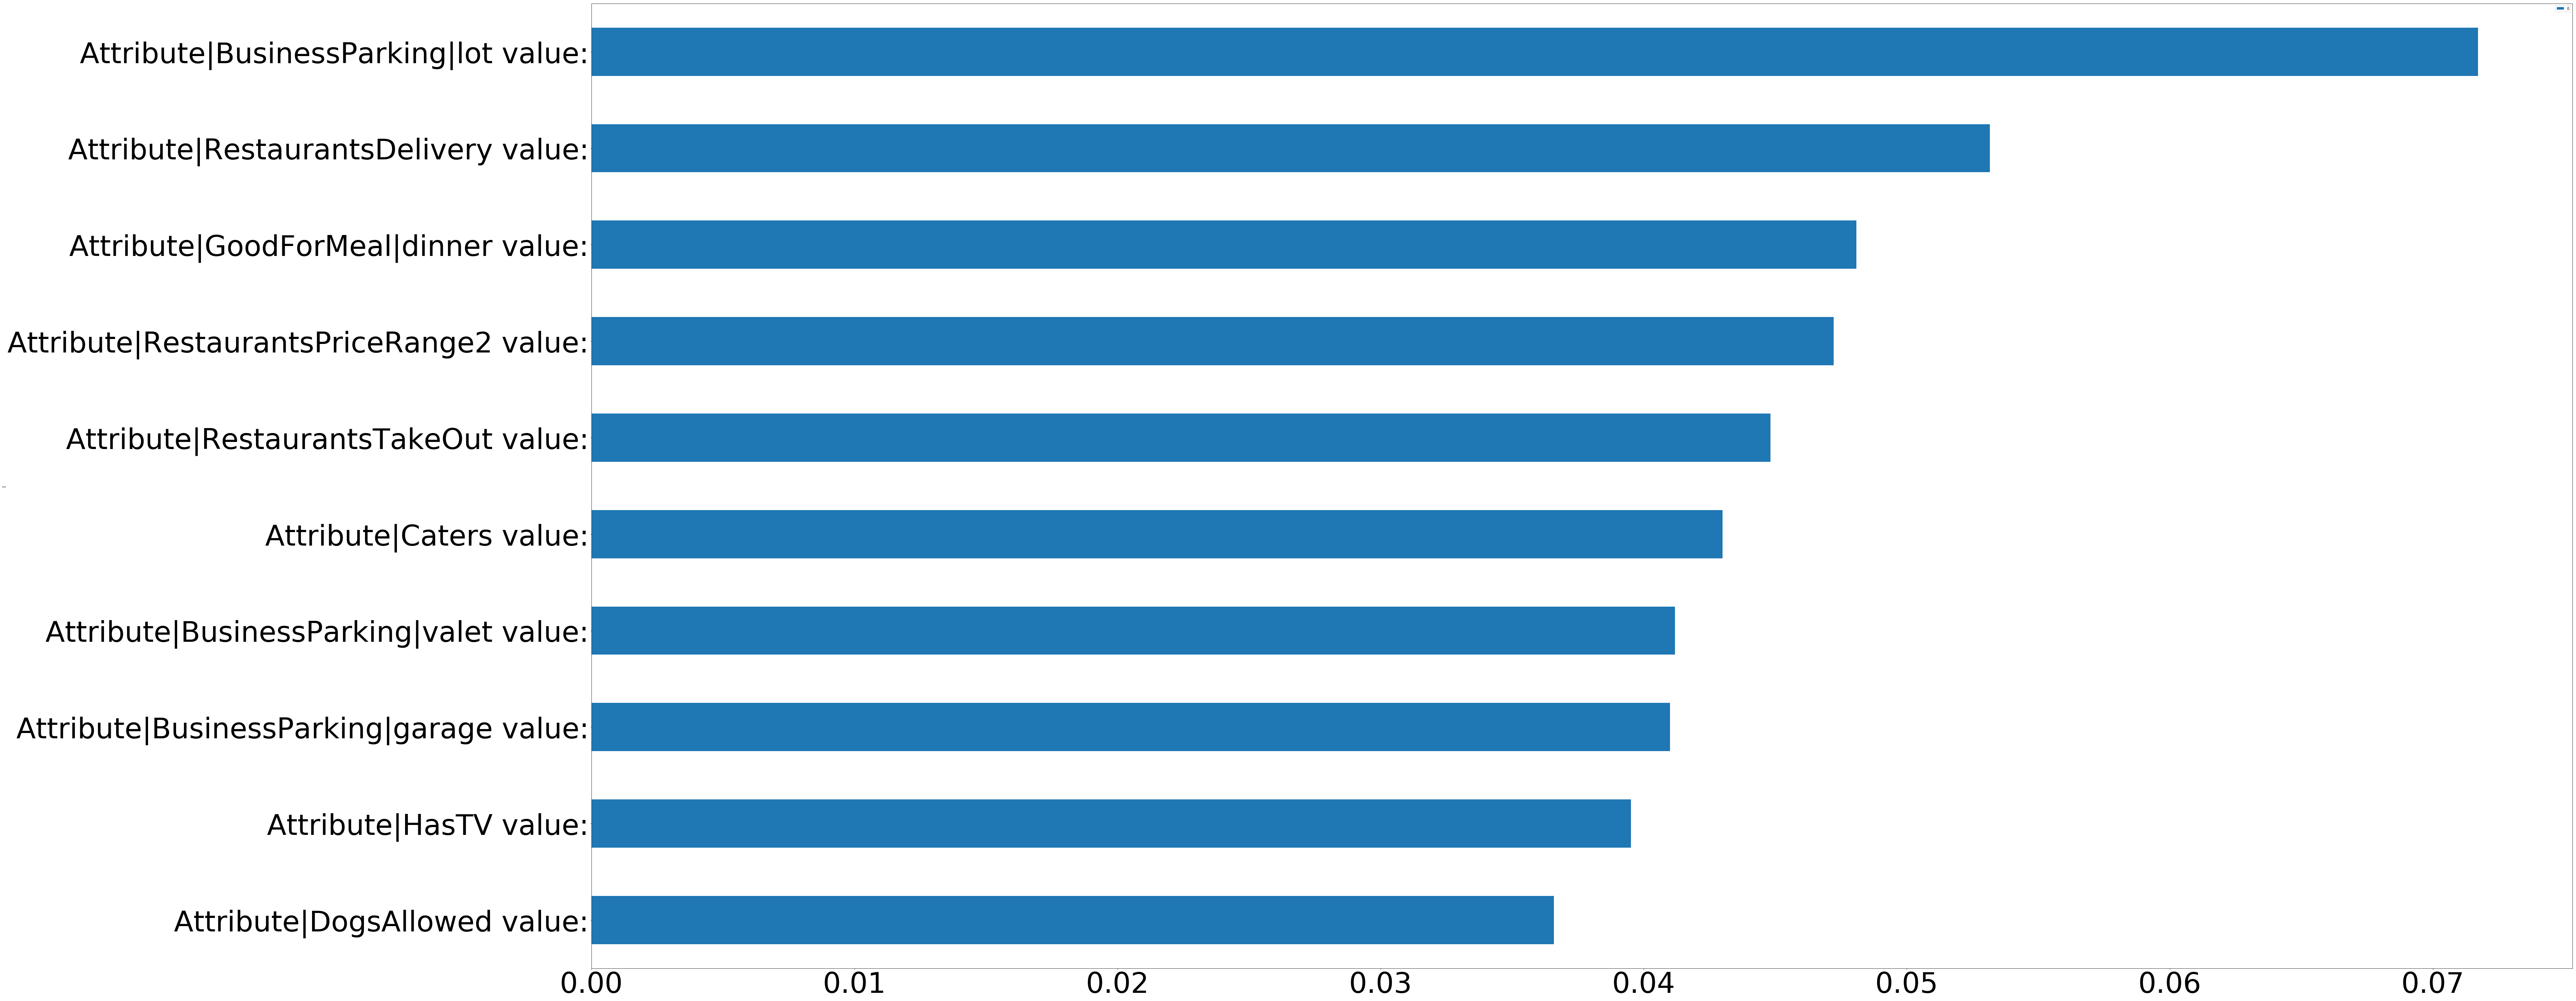

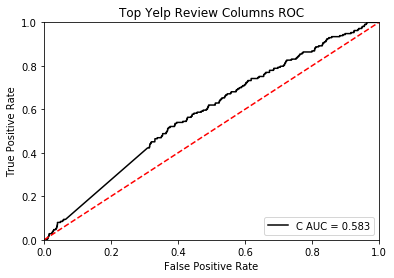

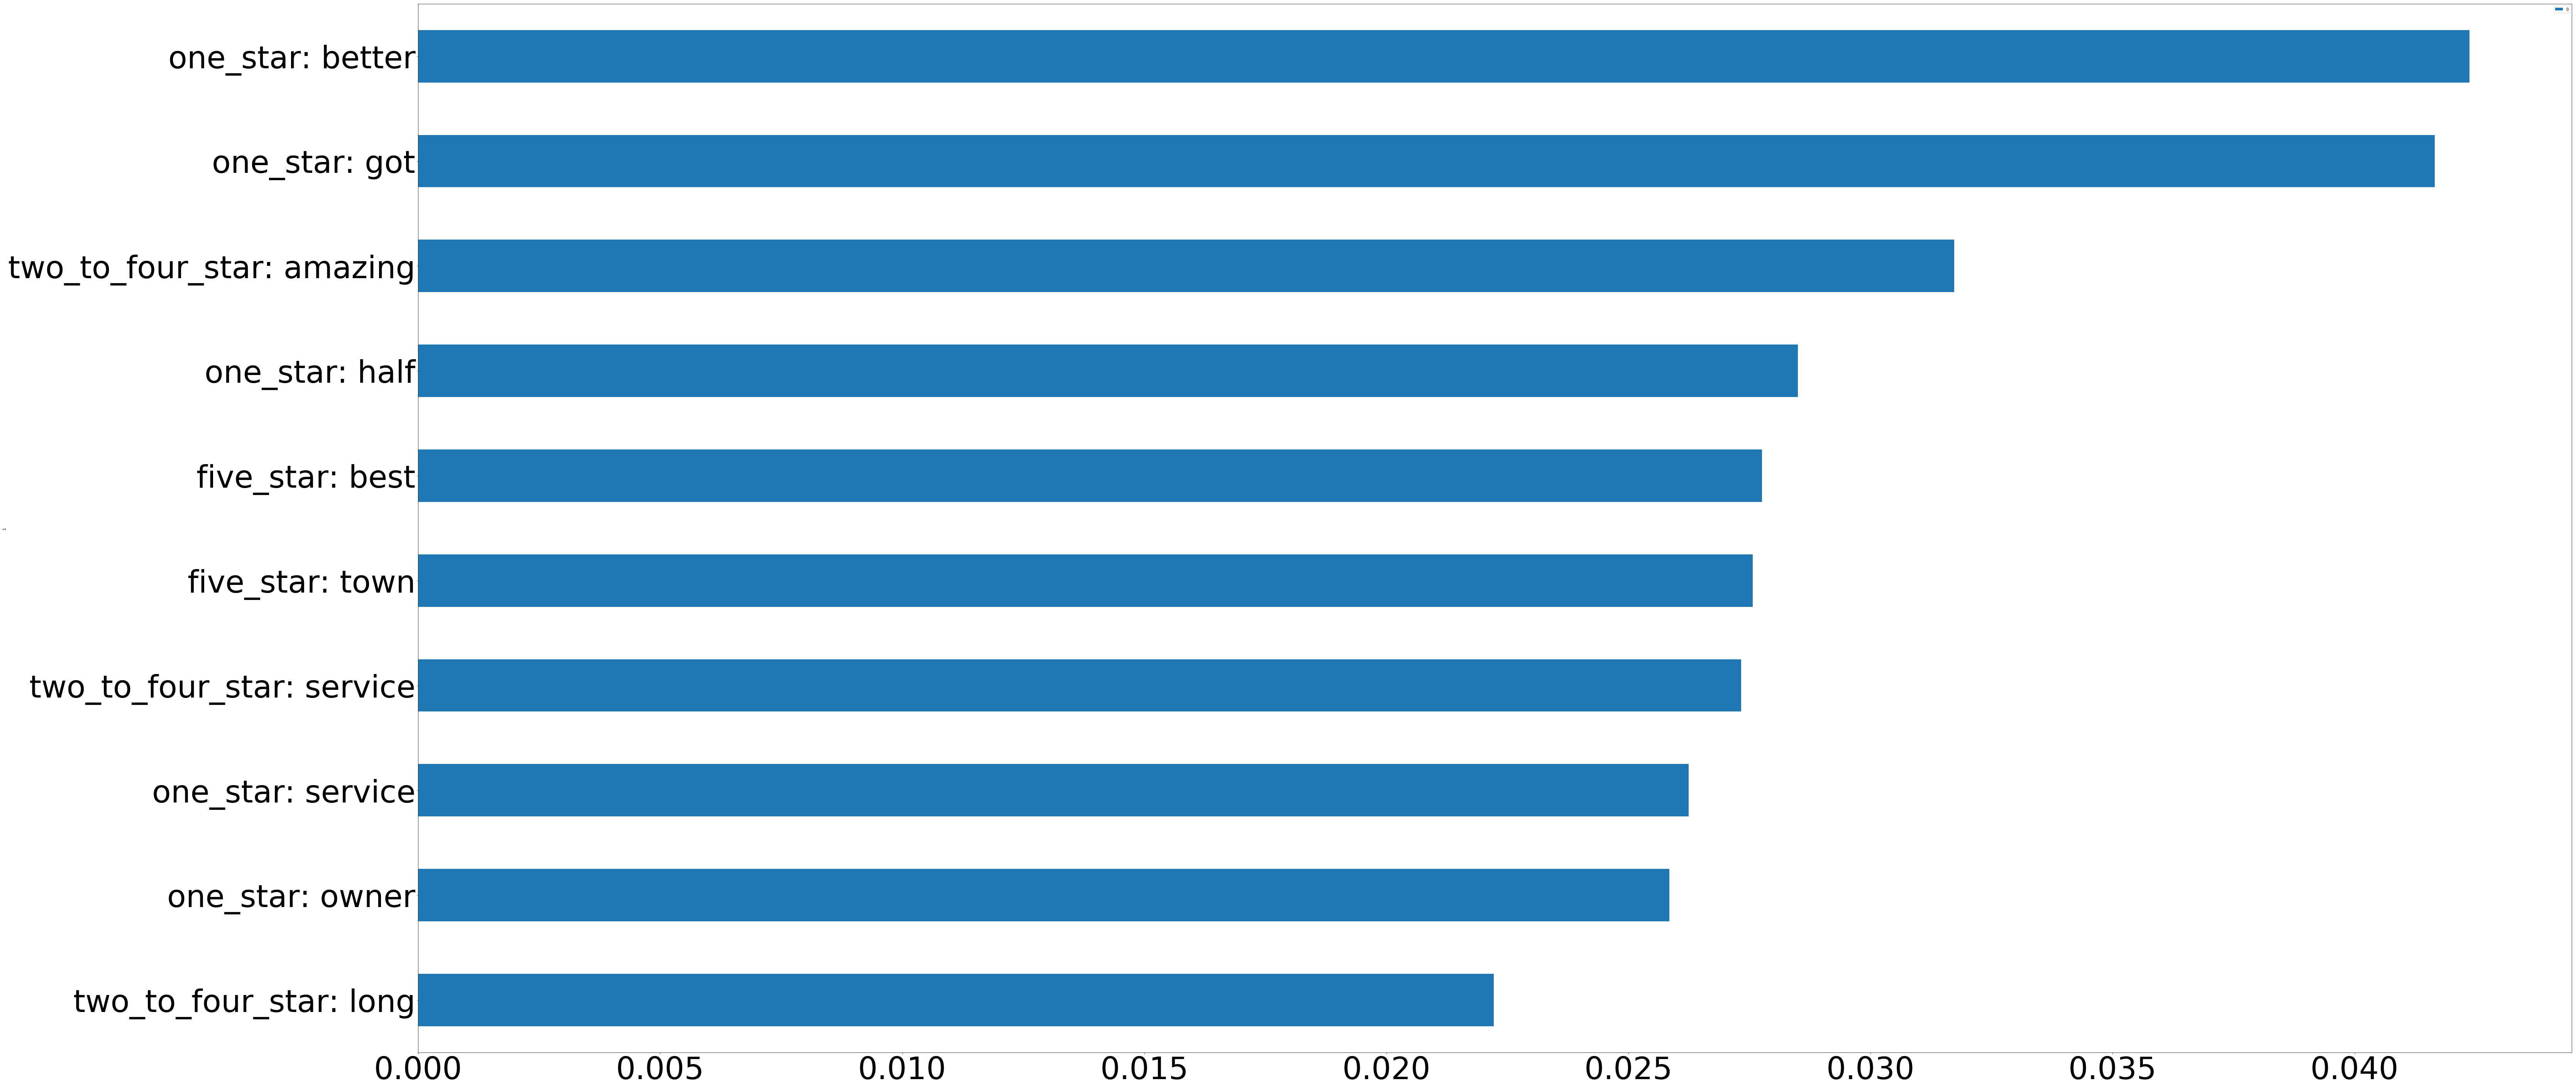

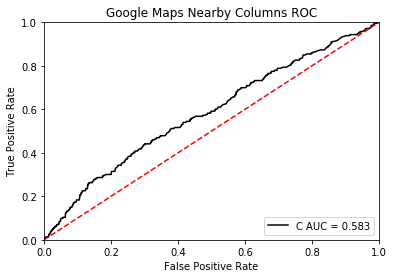

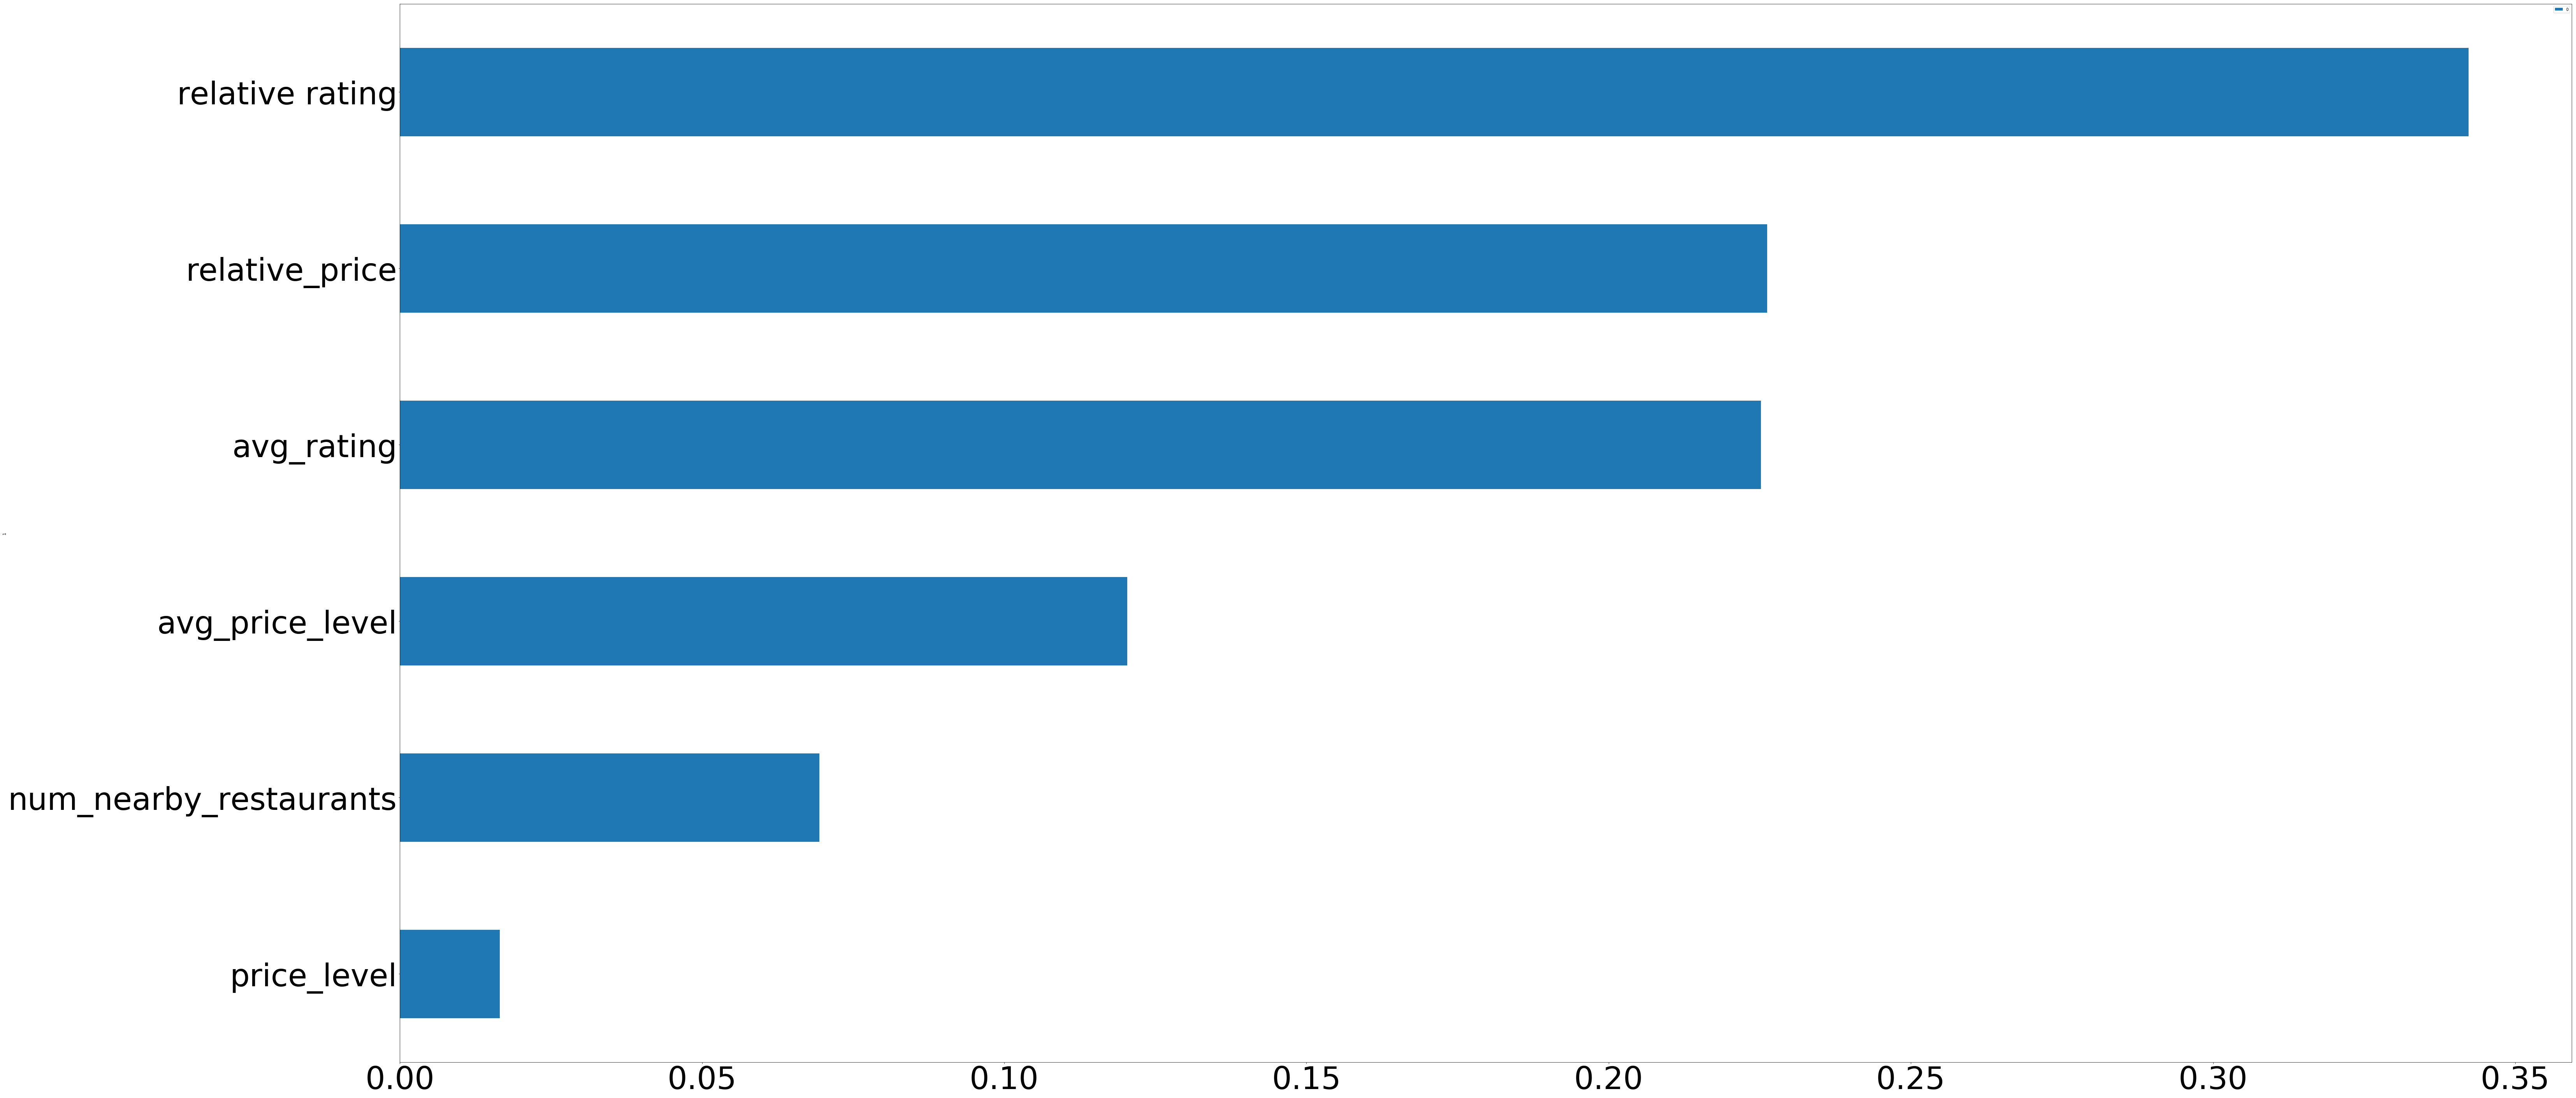

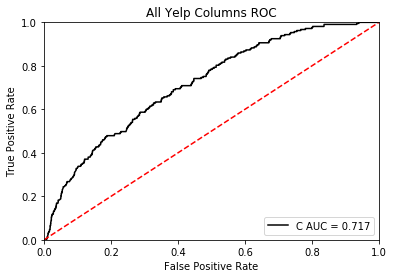

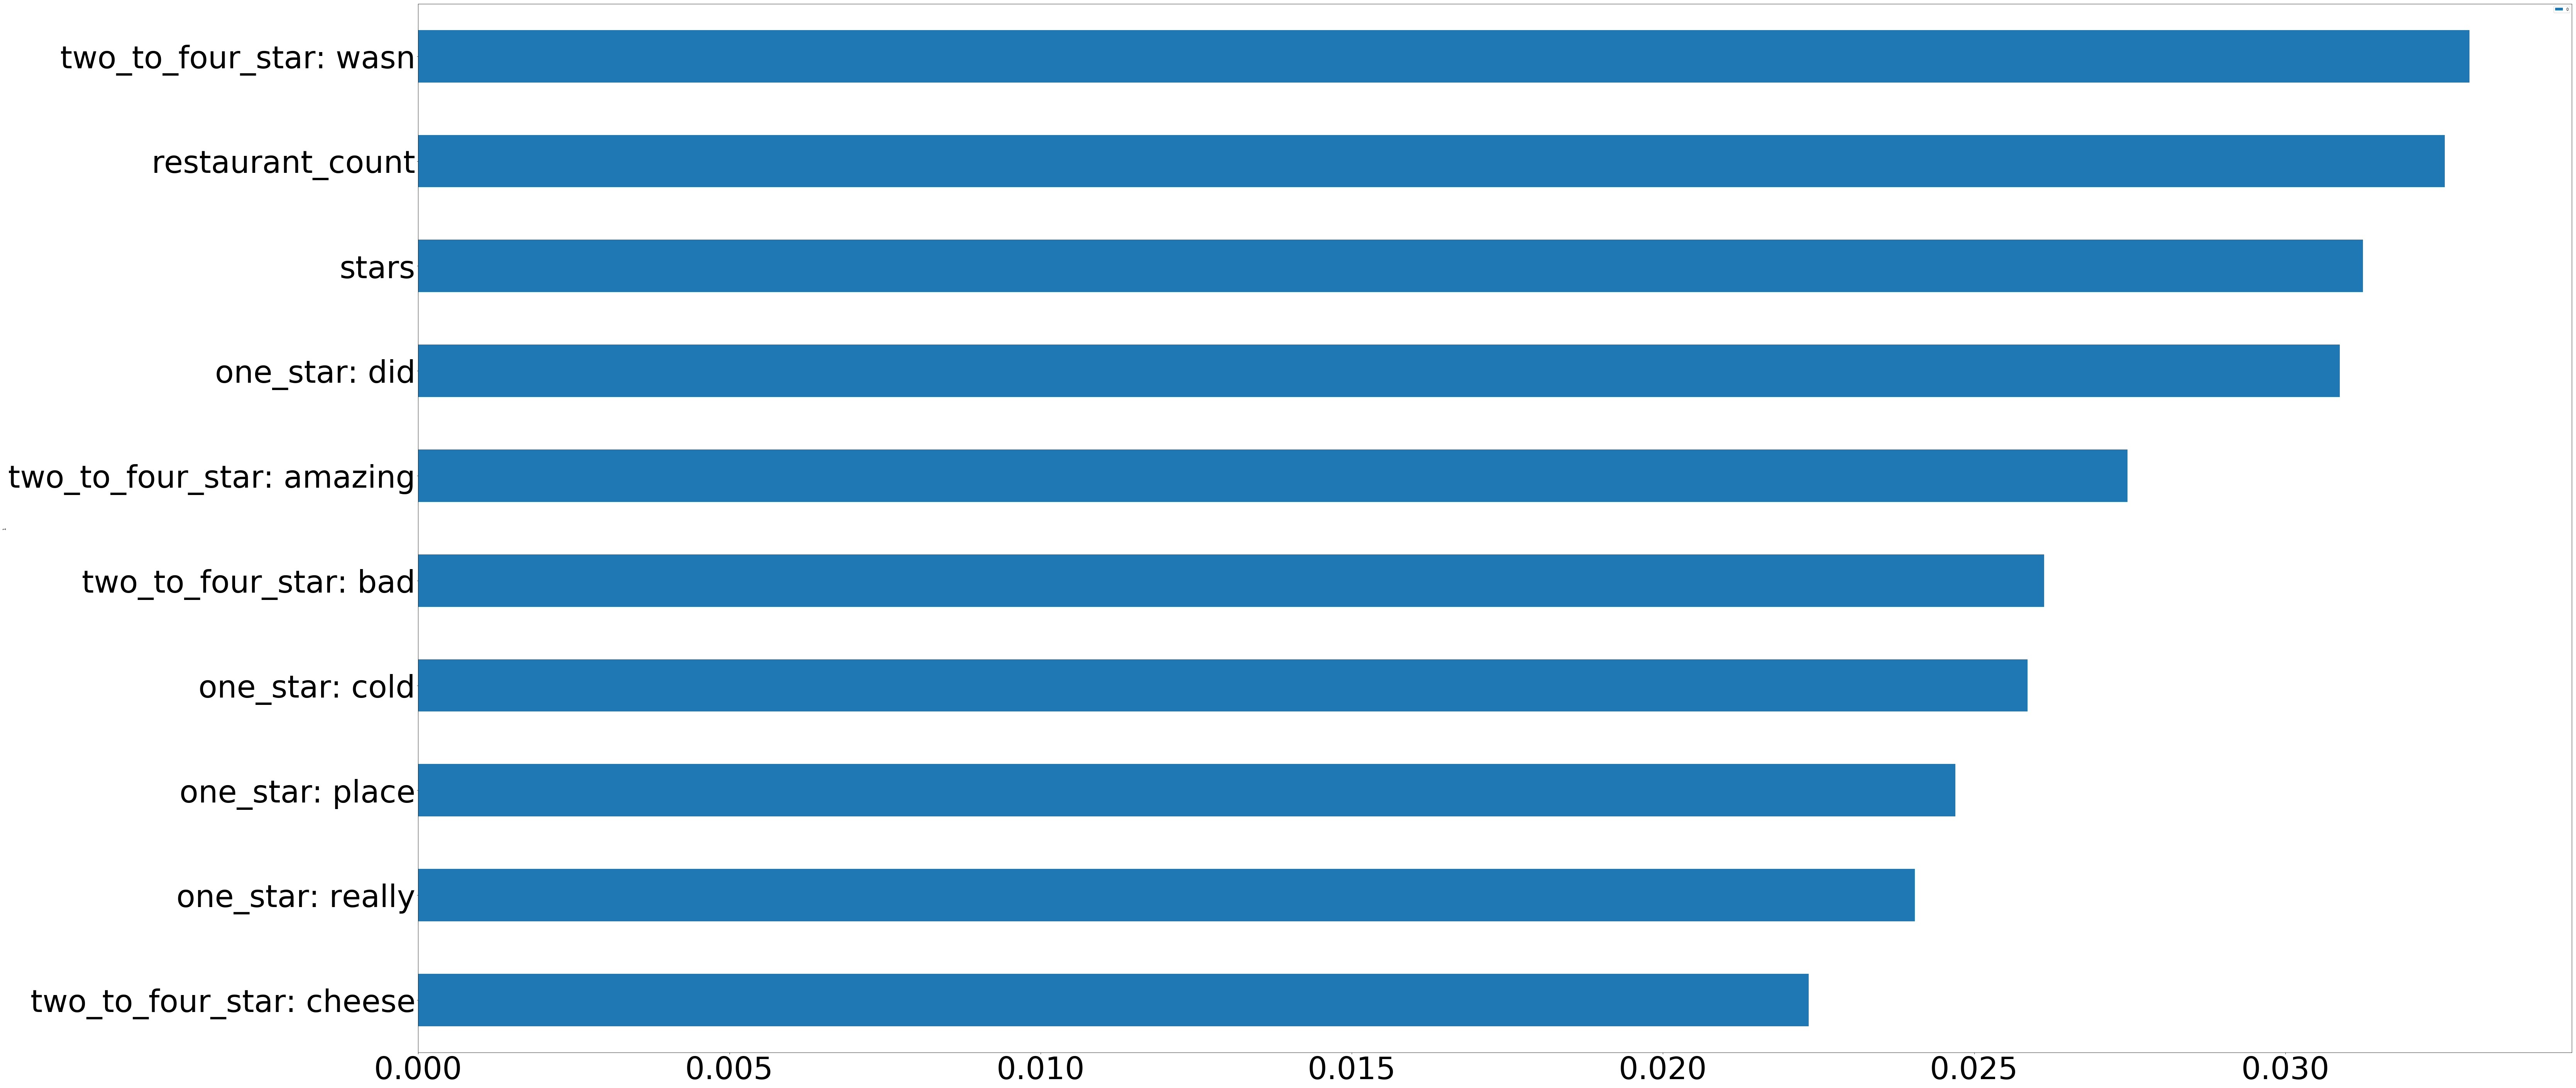

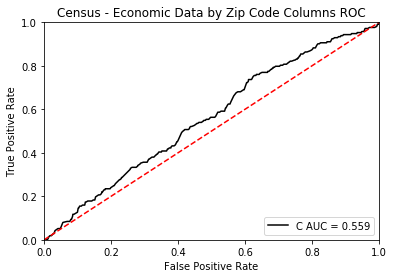

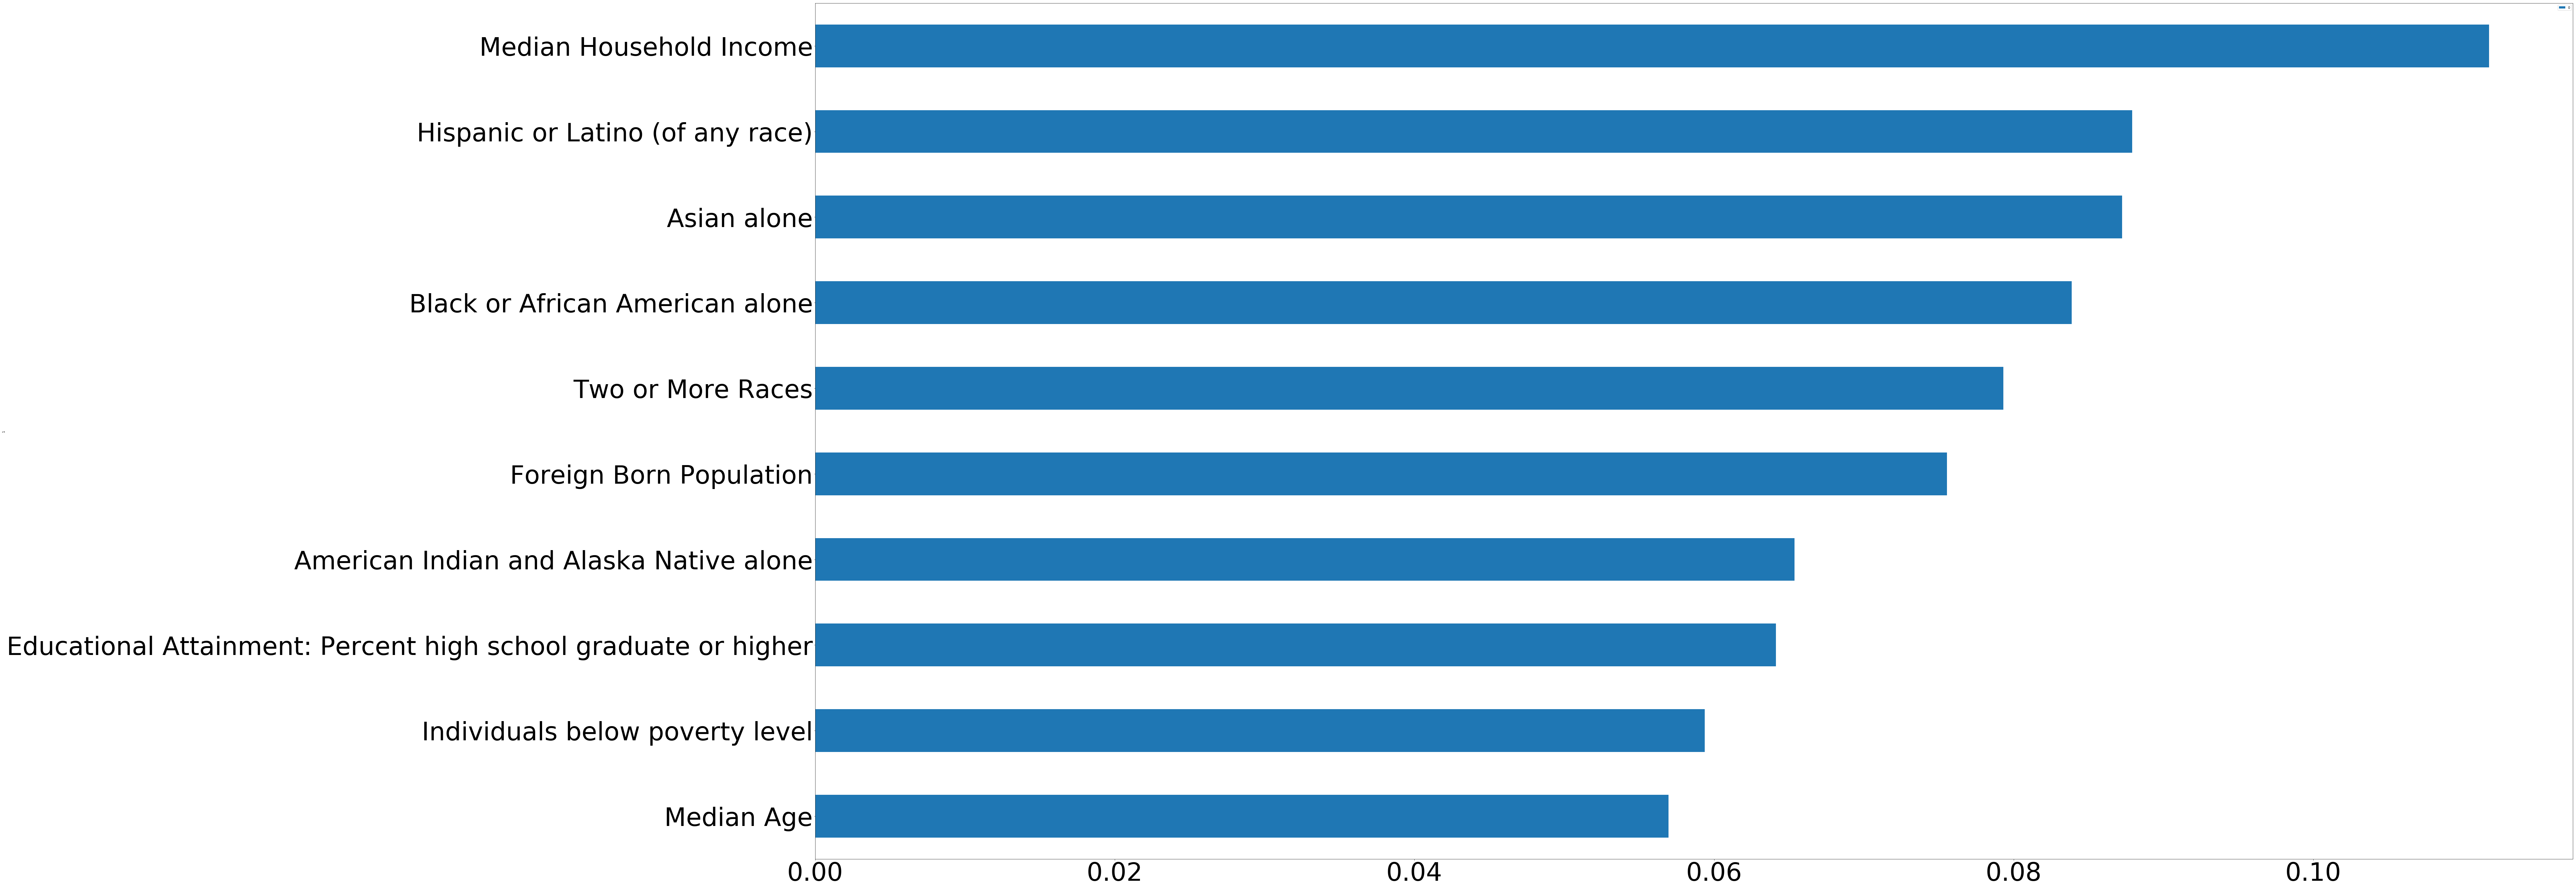

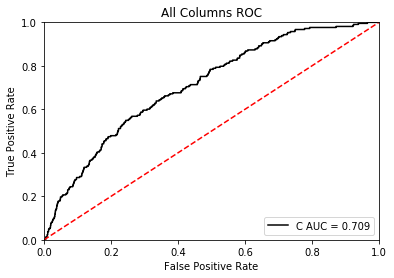

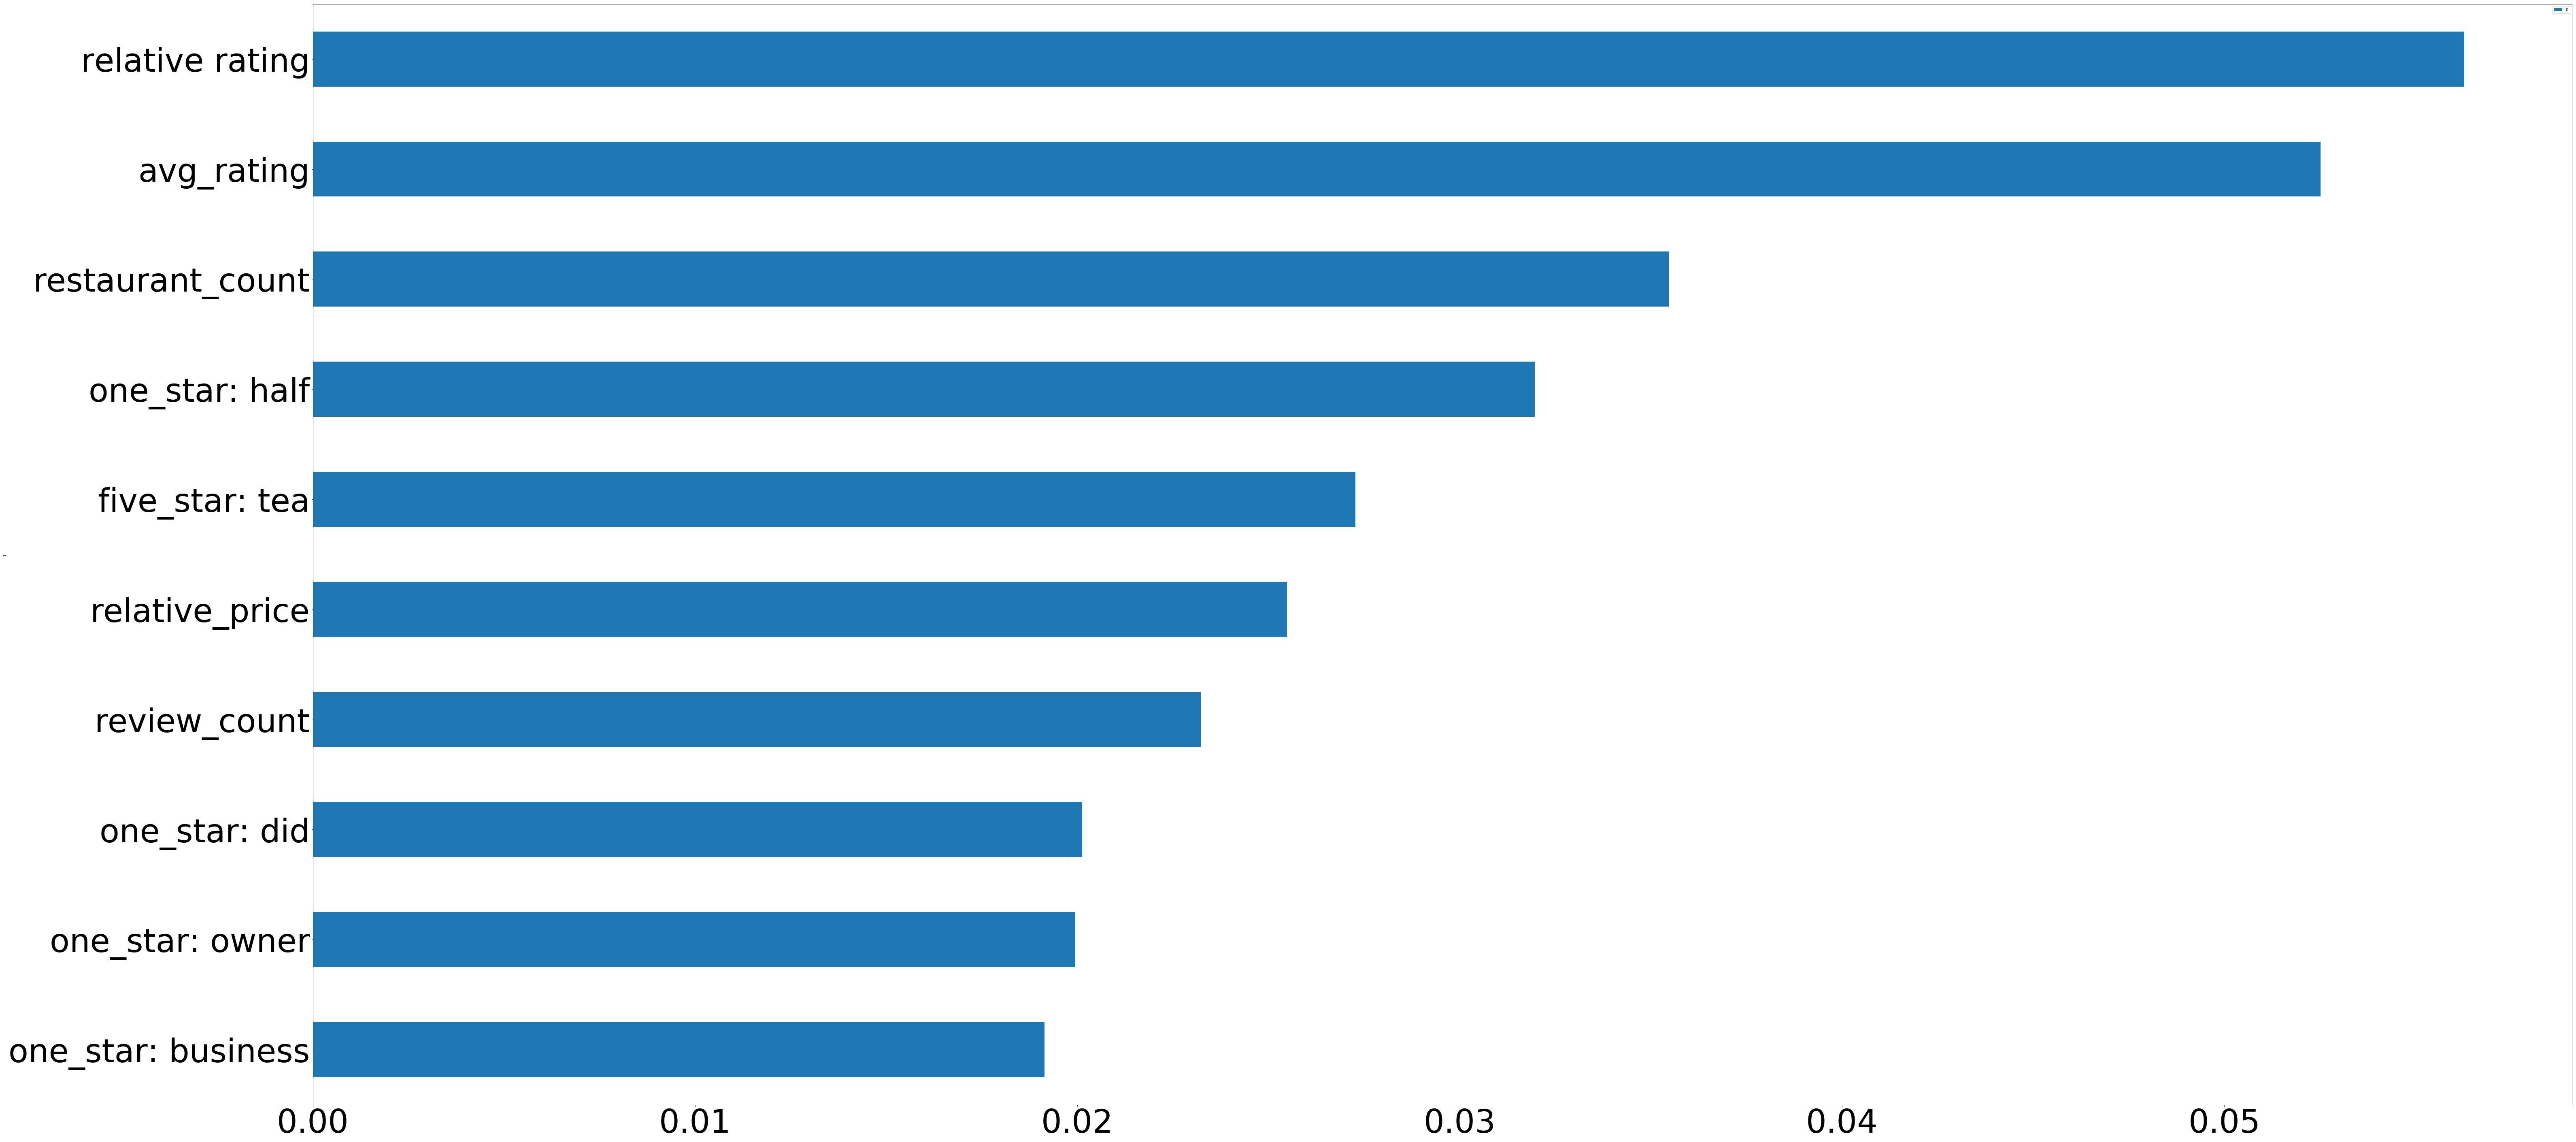

In [127]:
for key, value in x_column_sets.items():
    gb_model = GradientBoostingClassifier(n_estimators=100)
    gb_model.fit(X_train[value], y_train)
    plot_roc(gb_model, X_test[value], y_test, title=key + " Columns")
    best_values, best_features = get_best_features(gb_model, X_test[value].columns, 10)
    plot_best_features(best_values, best_features, 10, 100, 50)

In [129]:
all_values, all_features = get_best_features(gb_model, all_columns, len(all_columns))

feature_dict = x_column_sets
feature_category_values = {'yelp_columns':0, 'census_columns':0, \
                'price_and_nearby_columns':0,'top_review_columns':0}

feature_value_pairs = dict(list(zip(all_features, all_values)))

for key, values in feature_dict.items():
    for v in values:
        feature_category_values[key] += feature_value_pairs[v]

plot_best_features(list(feature_category_values.values()),list(feature_category_values.keys()), )

KeyboardInterrupt: 

([array([3929., 4121., 3701., 3271., 2531., 2249., 1545., 3149., 2967.,
         1793.]),
  array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
             0., 29256.])],
 array([   0. ,  761.6, 1523.2, 2284.8, 3046.4, 3808. , 4569.6, 5331.2,
        6092.8, 6854.4, 7616. ]),
 <a list of 2 Lists of Patches objects>)

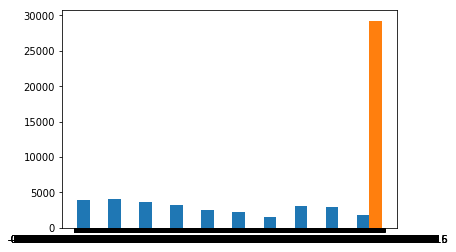

In [15]:
fig, ax = plt.subplots()
ax.hist(df[['relative rating','closed_on_google']])

In [16]:
df[['relative rating','closed_on_google']]

,relative rating,closed_on_google
0,-0.577778,False
1,0.783333,False
2,-0.011111,False
3,-1.933333,False
4,-0.100000,False
5,-0.790000,False
6,-0.240000,True
7,-3.185714,False
8,-1.169231,False
9,-0.500000,False


In [17]:
import autoregression

ModuleNotFoundError: No module named 'autoregression'

In [ ]:
autoregression.compare_predictions(df[census_columns + ['closed_on_google']],'closed_on_google')

In [ ]:
ls ../../..